# Original resource
https://github.com/cmsalgado/workshops
This was learned during TMU x MIT hackathon 2018 on 10/19 evening in Taipei.

# Objective and approach

This chapter aims to introduce clinicians to machine learning (ML), assuming no prior knowledge about machine learning and programming. It provides a guideline through the basic concepts underlying machine learning and the tools needed to easily implement it using Python frameworks. Basics of the Python language and Jupyter notebook environment will be covered. 

We will cover a large number of well-known ML algorithms, starting with the simplest (logistic regression and k-nearest neighbours) and ending with more complex ones (random forest), without going in much detail into the underlying mathematical theory. Instead, we will focus on explaining the intuitions behind algorithms so that you understand how they learn and how you can use and interpret them in any new problem.

A real-world clinical dataset will be used. It was constructed based on the code provided in https://github.com/YerevaNN/mimic3-benchmarks for the prediction of hospital mortality using data collected during the first two days in the ICU. The data were extracted from the MIMIC-III Clinical Database, which is a large, publicly-available database comprising de-identified electronic health records of approximately 60 000 ICU admissions. Patients stayed in the intensive care unit (ICU) of the Beth Israel Deaconess Medical Center between 2001 and 2012. MIMIC-III database is described in:

> Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, Mark RG. MIMIC-III, a freely accessible critical care database. Scientific Data (2016).

Before dwelling into ML, this chapter presentes all the steps required to transform raw data from eletronic health records into structured data that can be used as input to the learning algorithms. This is a crucial part of any ML project. The learning phase is divided in two main parts:

* **Patient stratification** through **unsupervised learning**
    * k-means clustering

* **Patient classification** through **supervised learning**
    * Feature selection
    * Logistic regression
    * Decision trees
    * Random forest

<img src="book_scheme.png" alt="Drawing" style="width: 500px;">

The first step is to import essential python libraries and MIMIC-III data.


# Import libraries and data


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import warnings

plt.style.use('ggplot')
warnings.filterwarnings("ignore")

Load data as a pandas DataFrame using the ICU stay ID as the DataFrame index, for facilitating data manipulation. This is achived by setting the 'index_col' parameter to the name of the index column.


In [2]:
# from local folder
data = pd.read_csv('/Users/catiasalgado/mimic3_mortality.csv', index_col='icustay')

# from dropbox
#data = pd.read_csv('https://www.dropbox.com/s/zninwtrkc6hv5g8/mimic3_mortality.csv?raw=1',index_col='icustay')

# Exploratory data analysis

A quick preview of data can be obtained using the 'head' function, which prints the first 5 rows of any given DataFrame:

In [3]:
data.head()

hours  diastolic BP  glasgow coma scale  glucose  heart rate  \
icustay                                                                     
282372.0  0.066667          60.0                 NaN      NaN       139.0   
282372.0  0.150000          73.0                 NaN      NaN       128.0   
282372.0  0.233333          81.0                 NaN      NaN       127.0   
282372.0  0.316667          86.0                 NaN      NaN       132.0   
282372.0  0.400000          86.0                 NaN      NaN       138.0   

             mean BP  oxygen saturation  respiratory rate  systolic BP  \
icustay                                                                  
282372.0   84.666702              100.0              20.0        134.0   
282372.0   93.000000              100.0              25.0        133.0   
282372.0   88.666702              100.0              22.0        104.0   
282372.0  100.000000              100.0              19.0        128.0   
282372.0  100.333000              100.0              21.0        129.0   

          temperature        age  gender  height  pH  weight  day  mortality  
icustay                                                                       
282372.0          NaN  48.682393     2.0     NaN NaN    59.0    1          1  
282372.0          NaN  48.682393     2.0     NaN NaN    59.0    1          1  
282372.0          NaN  48.682393     2.0     NaN NaN    59.0    1          1  
282372.0          NaN  48.682393     2.0     NaN NaN    59.0    1          1  
282372.0          NaN  48.682393     2.0     NaN NaN    59.0    1          1

It tells us that the dataset contains information regarding patient demographics: age, gender, weight, height, mortality; physiological vital signs: diastolic blood pressure, systolic blood pressure, mean blood pressure, temperature, respiratory rate; lab tests: glucose, pH; scores: glasgow coma scale. Each observation/row is associated with a time stamp (column 'hours'), indicating the number of hours since ICU admission where the observation was made. Each icustay has several observations for the same variable/column.
    
We can print the number of ICU stays by calculating the length of the unique indexes, number of missing data using the 'info' function and summary statistics using the 'describe' function:

In [4]:
print('Number of ICU stays: ' + str(len(data.index.unique())))
print('Number of survivors: ' + str(len(data[data['mortality']==0].index.unique())))
print('Number of non-survivors: ' + str(len(data[data['mortality']==1].index.unique())))
print('Mortality: ' + str(round(100*len(data[data['mortality']==1].index.unique()) / len(data.index.unique()),1)) + '%')
print()
display.display(data.info(null_counts=1))
display.display(data.describe())


Number of ICU stays: 21139
Number of survivors: 18342
Number of non-survivors: 2797
Mortality: 13.2%

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1461282 entries, 282372.0 to 245756.0
Data columns (total 17 columns):
hours                 1461282 non-null float64
diastolic BP          1015284 non-null float64
glasgow coma scale    159484 non-null float64
glucose               248463 non-null float64
heart rate            1057554 non-null float64
mean BP               1008434 non-null float64
oxygen saturation     1065422 non-null float64
respiratory rate      1066689 non-null float64
systolic BP           1015685 non-null float64
temperature           321850 non-null float64
age                   1461282 non-null float64
gender                1461282 non-null float64
height                455361 non-null float64
pH                    123580 non-null float64
weight                1309930 non-null float64
day                   1461282 non-null int64
mortality             1461282 

None

hours  diastolic BP  glasgow coma scale        glucose  \
count  1.461282e+06  1.015284e+06       159484.000000  248463.000000   
mean   2.182227e+01  6.105085e+01           11.600668     148.023205   
std    1.421245e+01  2.237985e+02            3.920855    2007.169359   
min    0.000000e+00 -1.300000e+01            3.000000       0.000000   
25%    8.938958e+00  5.100000e+01            9.000000     106.000000   
50%    2.091528e+01  5.900000e+01           14.000000     129.000000   
75%    3.404250e+01  6.800000e+01           15.000000     162.000000   
max    4.800000e+01  1.141090e+05           15.000000  999999.000000   

         heart rate       mean BP  oxygen saturation  respiratory rate  \
count  1.057554e+06  1.008434e+06       1.065422e+06      1.066689e+06   
mean   8.698175e+01  7.857446e+01       9.775436e+01      2.142277e+01   
std    1.994244e+01  1.474818e+02       9.505683e+02      2.280724e+03   
min    0.000000e+00 -3.700000e+01       0.000000e+00      0.000000e+00   
25%    7.400000e+01  6.700000e+01       9.600000e+01      1.500000e+01   
50%    8.500000e+01  7.600000e+01       9.800000e+01      1.900000e+01   
75%    9.900000e+01  8.700000e+01       1.000000e+02      2.300000e+01   
max    6.632000e+03  1.171200e+05       9.810230e+05      2.355555e+06   

        systolic BP    temperature           age        gender         height  \
count  1.015685e+06  321850.000000  1.461282e+06  1.461282e+06  455361.000000   
mean   1.197301e+02      37.008318  6.535809e+01  1.554603e+00     169.170224   
std    2.928788e+01       9.672449  1.663225e+01  4.970097e-01      14.552301   
min    0.000000e+00      -3.000000  1.803403e+01  1.000000e+00       0.000000   
25%    1.030000e+02      36.444444  5.474257e+01  1.000000e+00     163.000000   
50%    1.170000e+02      37.000000  6.738069e+01  2.000000e+00     170.000000   
75%    1.340000e+02      37.500000  7.862746e+01  2.000000e+00     178.000000   
max    1.375600e+04    5336.111111  9.000000e+01  2.000000e+00     445.000000   

                  pH        weight           day     mortality  
count  123580.000000  1.309930e+06  1.461282e+06  1.461282e+06  
mean        7.278925  8.280987e+01  1.439831e+00  1.505267e-01  
std         2.312467  2.575886e+01  4.963666e-01  3.575871e-01  
min         0.000000  0.000000e+00  1.000000e+00  0.000000e+00  
25%         7.310000  6.650000e+01  1.000000e+00  0.000000e+00  
50%         7.370000  7.910000e+01  1.000000e+00  0.000000e+00  
75%         7.420000  9.440000e+01  2.000000e+00  0.000000e+00  
max       733.000000  9.312244e+02  2.000000e+00  1.000000e+00

The dataset consists of 21,139 unique ICU stays and 1,461,282 observations. All columns with the exception of 'hours', 'mortality' and 'day' have missing information. Looking at the maximum and minimum values it is possible to spot the presence of outliers (e.g. max glucose). Both missing data and outliers are very common in ICU databases and need to be taken into consideration before applying ML algorithms.


## Variable selection

There should be a trade-off between the potential value of the variable in the model and the amount of data available. We already saw the amount of missing data for every column, but we still do not know how much information is missing at the patient level. In order to do so, we are going to aggregate data by ICU stay and look at the number of non-null values, using the 'groupby' function together with the 'mean' operator. This will give an indication of how many ICU stays have at least one observation for each variable. 

We will consider every ICU stay as an independent sample. 


In [5]:
print(data.groupby(['icustay']).mean().info(null_counts=1))

<class 'pandas.core.frame.DataFrame'>
Float64Index: 21139 entries, 200001.0 to 299995.0
Data columns (total 17 columns):
hours                 21139 non-null float64
diastolic BP          19154 non-null float64
glasgow coma scale    10993 non-null float64
glucose               18745 non-null float64
heart rate            19282 non-null float64
mean BP               19123 non-null float64
oxygen saturation     19305 non-null float64
respiratory rate      19367 non-null float64
systolic BP           19154 non-null float64
temperature           18440 non-null float64
age                   21139 non-null float64
gender                21139 non-null float64
height                5370 non-null float64
pH                    15489 non-null float64
weight                18181 non-null float64
day                   21139 non-null float64
mortality             21139 non-null float64
dtypes: float64(17)
memory usage: 2.9 MB
None


* Height can be discarded due to the high amount of missing data;

* Weight and height are typically used in combination (body mass index), since alone they provide low predictive power. Therefore, weight can also be discarded;

* The other variables will be kept. Let us start with time-variant variables and set aside age and gender for now:


In [6]:
variables = ['diastolic BP', 'glasgow coma scale',
             'glucose', 'heart rate', 'mean BP',
             'oxygen saturation', 'respiratory rate', 'systolic BP',
             'temperature', 'pH']
variables_mort = variables.copy()
variables_mort.append('mortality')

# Data preprocessing
## Outliers
### Data visualization

Using the 'seaborn' library and the 'boxplot' function we can easily create one boxplot for every variable.

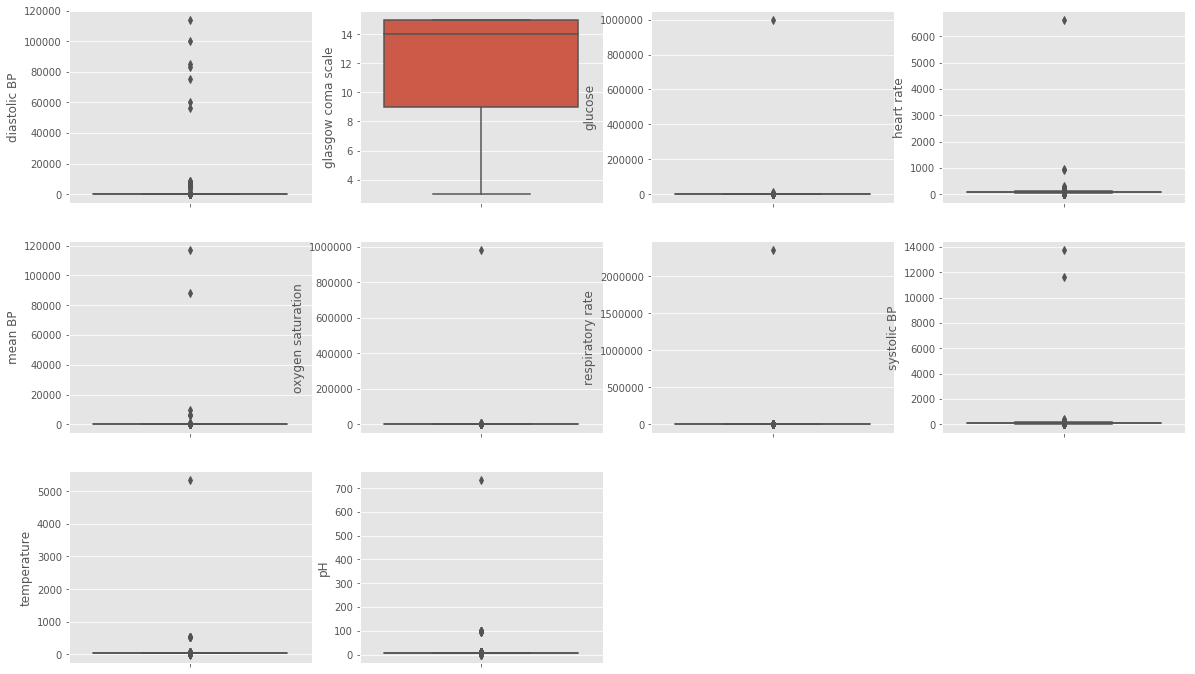

In [7]:
import seaborn as sns

fig = plt.figure(figsize=(20,12))
count = 0
for variable in variables:
    count += 1
    plt.subplot(3, 4, count)
    
    ax = sns.boxplot(y=variable, data=data)
    #ax = sns.stripplot(y=variable, data=data, color="orange", jitter=0.2, size=0.5)
    
    # same but partitioned by outcome
    #ax = sns.boxplot(x = 'mortality', y=variable, data=data)
    #ax = sns.stripplot(x = 'mortality', y=variable, data=data, color="orange", jitter=0.2, size=0.5)

plt.show()

In some cases, the outliers are so deviant from the norm that it is not even possible to visualize the distribution of data (minimum, first quartile, median, third quartile, maximum) using boxplots. 

There are other plot types you can create to investigate the presence of outliers. Simply plotting all points using a scatter plot, or using violin plots are some of the options. 

### Exclusion

Ideally, we should keep extreme values related to the patients' poor health condition, and exclude impossible values (such as negative temperature) and probable outliers (such as heart rate above 250 beats/min). In order to do so, values that fall outside boudaries defined by expert knowledge will be excluded. This will avoid excluding extreme (but correct/possible) values.


In [8]:
nulls_before = data.isnull().sum().sum()

data.loc[data['diastolic BP']>300, 'diastolic BP'] = np.nan
data.loc[data['glucose']>2000, 'glucose'] = np.nan
data.loc[data['heart rate']>400, 'heart rate'] = np.nan
data.loc[data['mean BP']>300, 'mean BP'] = np.nan
data.loc[data['mean BP']<0, 'mean BP'] = np.nan
data.loc[data['systolic BP']>10000,  'systolic BP'] = np.nan
data.loc[data['temperature']>50, 'temperature'] = np.nan
data.loc[data['temperature']<20, 'temperature'] = np.nan
data.loc[data['pH']>7.8, 'pH'] = np.nan
data.loc[data['pH']<6.8, 'pH'] = np.nan
data.loc[data['respiratory rate']>300, 'respiratory rate'] = np.nan
data.loc[data['oxygen saturation']>100, 'oxygen saturation'] = np.nan
data.loc[data['oxygen saturation']<0, 'oxygen saturation'] = np.nan

nulls_now = data.isnull().sum().sum()
print('Number of observations removed: ' + str(nulls_now - nulls_before))
print('Observations corresponding to outliers: ' + str(round((nulls_now - nulls_before)*100/data.shape[0],2)) + '%')


Number of observations removed: 7783
Observations corresponding to outliers: 0.53%


### Data visualization after outliers exclusion

The same code can be used to verify the data distribution after exclusion of outliers. The 'stripplot' function allows to visualize the underlying distribution and the number of observations. Setting x = 'mortality' shows the boxplots partitioned by outcome.

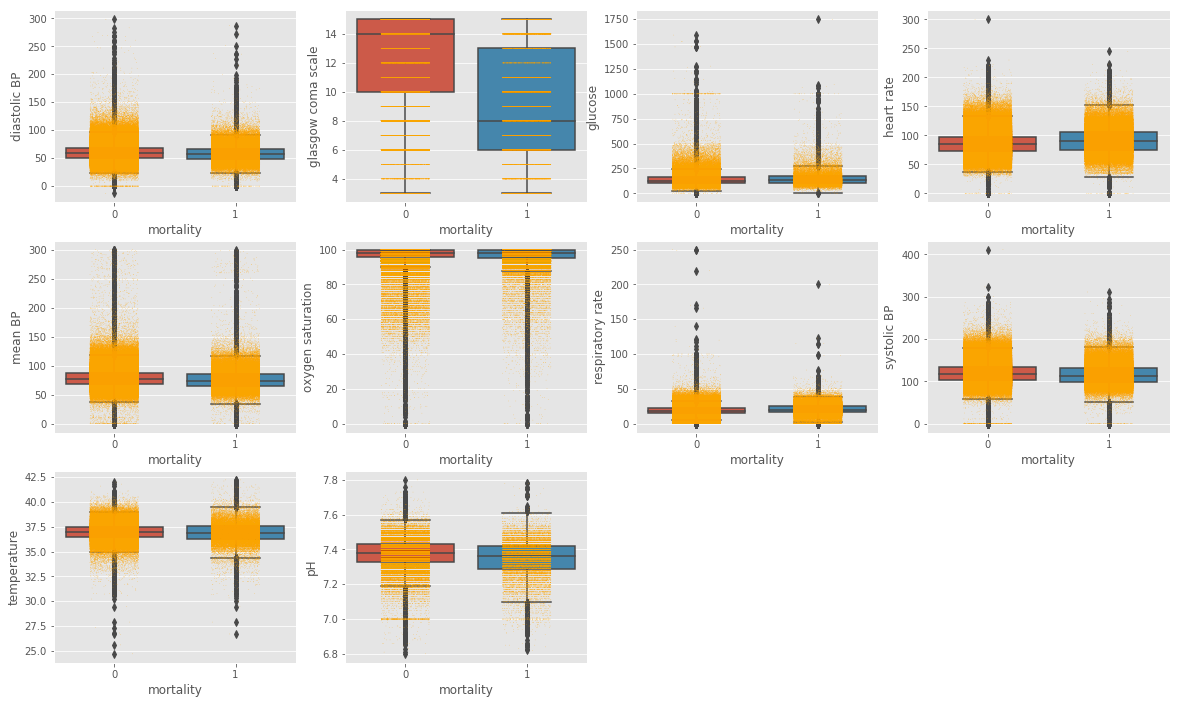

In [9]:
fig = plt.figure(figsize=(20,12))
count = 0
for variable in variables:
    count += 1
    plt.subplot(3, 4, count)
    
    #ax = sns.boxplot(y=variable, data=data)
    #ax = sns.stripplot(y=variable, data=data, color="orange", jitter=0.2, size=0.5)
    
    # same but partitioned by outcome
    ax = sns.boxplot(x = 'mortality', y=variable, data=data)
    ax = sns.stripplot(x = 'mortality', y=variable, data=data, color="orange", jitter=0.2, size=0.5)

plt.show()

## Aggregate data by hour

To allow for ease of comparison, individual data is condensed into hourly observations by selecting the median value of the available observations within each hour. First, the 'floor' operator is applied in order to categorize the hours in 48 bins (hour 0, hour 1, ..., hour 47). Then, the 'groupby' function with the 'median' operator is applied in order to get the median heart rate for each hour of each ICU stay.

In [10]:
data['hour'] = data['hours'].apply(np.floor)

# data goes until h = 48, change 48 to 47
data.loc[data['hour'] == 48, 'hour'] = 47


In [11]:
data.head()

hours  diastolic BP  glasgow coma scale  glucose  heart rate  \
icustay                                                                     
282372.0  0.066667          60.0                 NaN      NaN       139.0   
282372.0  0.150000          73.0                 NaN      NaN       128.0   
282372.0  0.233333          81.0                 NaN      NaN       127.0   
282372.0  0.316667          86.0                 NaN      NaN       132.0   
282372.0  0.400000          86.0                 NaN      NaN       138.0   

             mean BP  oxygen saturation  respiratory rate  systolic BP  \
icustay                                                                  
282372.0   84.666702              100.0              20.0        134.0   
282372.0   93.000000              100.0              25.0        133.0   
282372.0   88.666702              100.0              22.0        104.0   
282372.0  100.000000              100.0              19.0        128.0   
282372.0  100.333000              100.0              21.0        129.0   

          temperature        age  gender  height  pH  weight  day  mortality  \
icustay                                                                        
282372.0          NaN  48.682393     2.0     NaN NaN    59.0    1          1   
282372.0          NaN  48.682393     2.0     NaN NaN    59.0    1          1   
282372.0          NaN  48.682393     2.0     NaN NaN    59.0    1          1   
282372.0          NaN  48.682393     2.0     NaN NaN    59.0    1          1   
282372.0          NaN  48.682393     2.0     NaN NaN    59.0    1          1   

          hour  
icustay         
282372.0   0.0  
282372.0   0.0  
282372.0   0.0  
282372.0   0.0  
282372.0   0.0

In [12]:
data_median_hour = data.groupby(['icustay','hour'])[variables_mort].median()
data_median_hour.head()


diastolic BP  glasgow coma scale  glucose  heart rate  mean BP  \
icustay  hour                                                                   
200001.0 0.0           65.0                 NaN      NaN       113.5     76.5   
         1.0           68.0                 NaN      NaN       108.0     79.0   
         2.0           68.0                 NaN    118.0       110.0     79.0   
         3.0           61.0                 NaN      NaN       102.0     71.0   
         4.0           58.0                 NaN      NaN       108.0     69.0   

               oxygen saturation  respiratory rate  systolic BP  temperature  \
icustay  hour                                                                  
200001.0 0.0                95.0              22.0        111.5    37.277778   
         1.0                98.0              18.0        113.0          NaN   
         2.0                98.0              27.0        116.0          NaN   
         3.0                96.0              21.0        102.0    37.666667   
         4.0                94.0              19.0        103.0          NaN   

                 pH  mortality  
icustay  hour                   
200001.0 0.0   7.41          0  
         1.0    NaN          0  
         2.0    NaN          0  
         3.0    NaN          0  
         4.0    NaN          0

The 'groupby' will create as many indexes as groups defined. In order to facilitate the next operations, a single index is desirable. In the next example, the second index (hour column) is excluded and kept as a DataFrame column. Note that the first index corresponds to level 0 and second index to level 1. Therefore, in order to exclude the second index and keep it as a column, 'level' should be set to 1 and 'drop' to False.

In [13]:
data_median_hour = data_median_hour.reset_index(level=(1), drop = False)


The next example shows the vital signs for a specific ICU stay ID. Consecutive hourly observations are connected by line. 

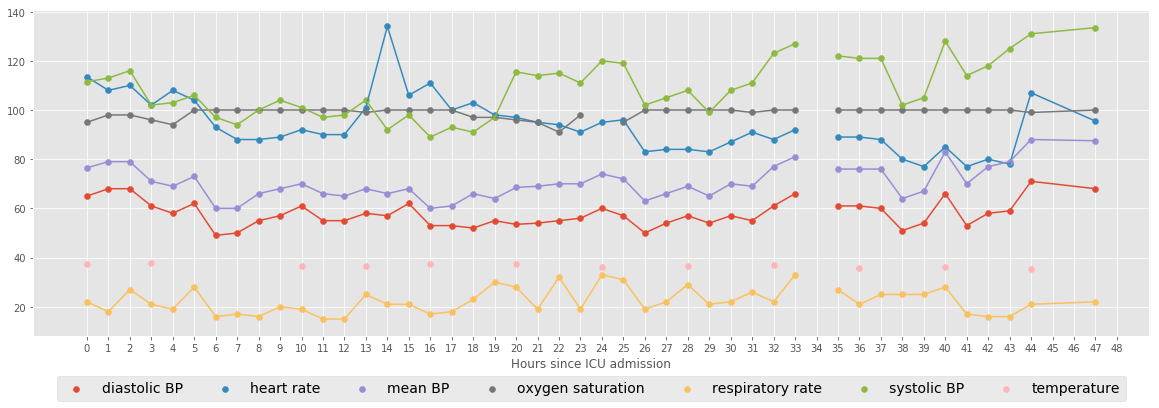

In [14]:
vitals = ['diastolic BP', 'heart rate', 'mean BP', 'oxygen saturation', 
          'respiratory rate', 'systolic BP','temperature']
ICUstayID = 200001.0

fig, ax = plt.subplots(figsize=(20,6))

# scatter plot
for col in vitals:
    ax.scatter(data_median_hour.loc[ICUstayID,'hour'], data_median_hour.loc[ICUstayID,col])
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=len(vitals), prop={'size': 14})
    plt.xticks(np.arange(0, 49, step=1))
    plt.xlabel('Hours since ICU admission')
    
# connect consecutive points by line
for col in vitals:    
    ax.plot(data_median_hour.loc[ICUstayID,'hour'], data_median_hour.loc[ICUstayID,col])

## Select minimum number of observations

We decided to keep all the time-variant variables available. However, and as you can see in the previous example, since not all variables have a hourly sampling rate, a lot of information is missing (coded as NaN). In order to train ML algorithms it is important to decide how to handle the missing information. Two options are: to replace the missing information with some value or to exclude the missing information. In this work, we will avoid introducing bias resultant from replacing missing values with estimated values (which is not the same as saying that this is not a good option in some situations). Instead, we will focus on a complete case analysis, i.e., we will include in our analysis only those patients who have complete information.

Depending on how we will create the feature set, complete information can have different meanings. For example, if we want to use one observation for every hour, complete information is to have no missing data for every t=0 to t=47, which would lead to the exclusion of the majority of data. However, if we want to reduce the size of the feature space, we can select only some portions of the time series. In this case, it is important to define the minimum length of the time series before starting to select portions of it. One possible approach is to use all patients who have at least one observation per variable. However, we will be more conservative and say that we want at least two observations per variable. 

In the following function, setting 'min_num_meas = 2' means that we are selecting ICU stays where each variable was recorded at least once at two different hours. Again, we are using the 'groupby' function to aggregate data by ICU stay, and the 'count' operator to count the number of observations for each variable. We then excluded ICU stays where some variable was recorded less than 2 times. Later on this chapter we will show how to extract features from the time series, in order to reduce the size of the feature space.

In [15]:
min_num_meas = 2

def extr_min_num_meas(data_median_hour, min_num_meas):
    """ Select ICU stays where there are at least 'min_num_meas' observations 
    and print the resulting DataFrame size"""
    data_count = data_median_hour.groupby(['icustay'])[variables_mort].count()

    for col in data_count:
        data_count[col] = data_count[col].apply(lambda x: np.nan if x < min_num_meas else x)

    data_count = data_count.dropna(axis=0, how='any')
    print('Number of ICU stays: ' + str(data_count.shape[0]))
    print('Number of features: ' + str(data_count.shape[1]))
    unique_stays = data_count.index.unique()

    data_median_hour = data_median_hour.loc[unique_stays]
    
    return data_median_hour

data_median_hour = extr_min_num_meas(data_median_hour, min_num_meas)

Number of ICU stays: 6931
Number of features: 11


The size of data is decreasing. We started with a database of around 60,000 ICU stays, imported a fraction of those that satisfied some criteria, in a total of 21,140 ICU stays, and are now looking at 6,931 ICU stays.

# Exploratory (preprocessed-)data analysis


## Pairwise ploting

One of the most used techniques in exploratory data analysis is the pairs plot (also called scatterplot). This technique allows to see both the distribuition of single variables as well as relationships between every two variables. It is easily implemented in Python thanks to the seaborn library. The next example shows the pairwise relationships between variables and the histograms of single variables partitioned by outcome (survival vs non-survival). A subset of data is used: 'dropna(axis=0, how='any')' will exclude all rows containing missing information.


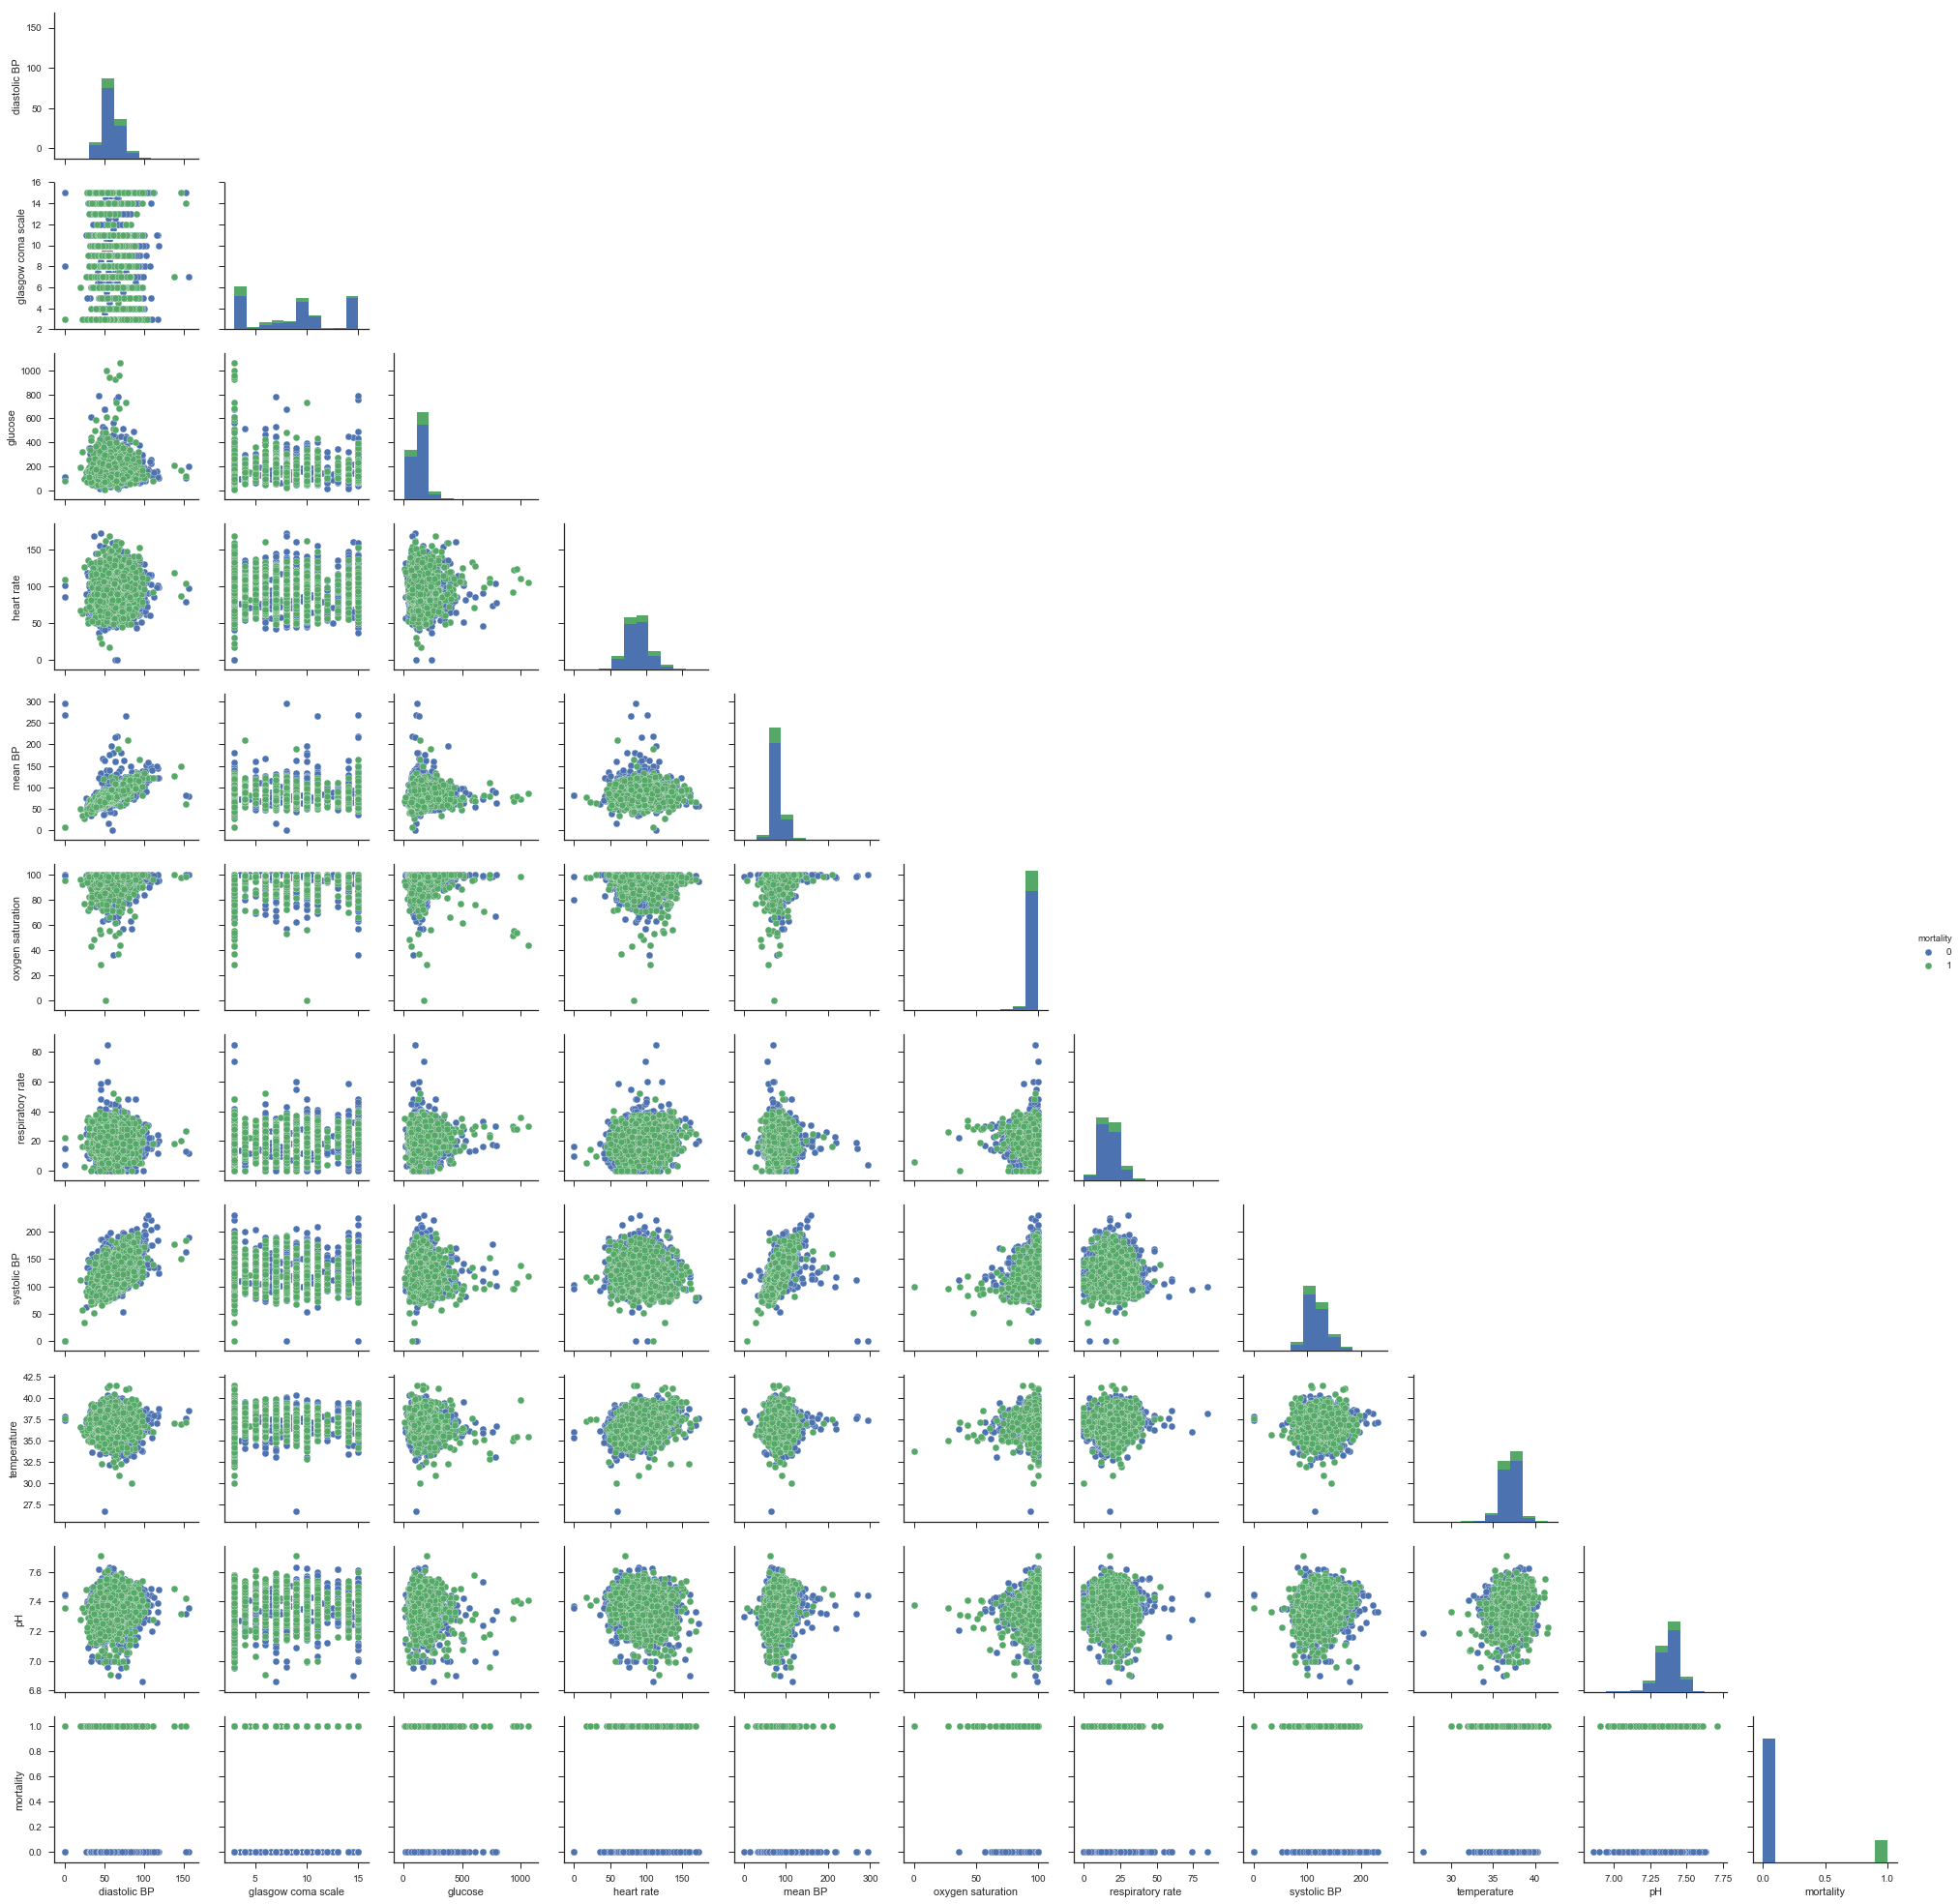

In [16]:
sns.set(style="ticks")
g = sns.pairplot(data_median_hour[variables_mort].dropna(axis=0, how='any'), hue = 'mortality')

# hide the upper triangle
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
plt.show()

# change back to our preferred style
plt.style.use('ggplot')

This type of plot only allows to see relationships in a 2D space, which in most cases is not enough to find any patterns or trends. Nonetheless, it is still able to tell us important aspects of data; if not for showing promising directions for data analysis, to provide a means to check data's integrity. Things to highlight are:

* Hypoxic patients generally have lower SBPs
* SBP correlates with MAP, which is a nice test of the data's integrity
* Fever correlates with increasing tachycardia, also as expected

## Time series ploting

In order to investigate trends across time, it is useful to visualize the mean HR partitioned by outcome from t=0 to t=47. In order to easily perform this task, the DataFrame needs to be reestructured.

The next function takes as input a pandas DataFrame and the name of the variable and transposes/pivots the DataFrame in order to have columns corresponding to time (t=0 to t=47) and rows corresponding to ICU stays. If 'filldata' is set to 1, the function will fill missing information using the forward fill method, where NaNs are replaced by the value preceding it. In case no value is available for forward fill, NaNs are replaced by the next value in the time series. The function 'fillna' with the method parameter set to 'ffill' and 'bfill', allows us to easily perform these two actions. If 'filldata' is set to 0 no missing data imputation is performed.

In [17]:
def timeseries_data(data_median_hour, variable, filldata = 1):
    """Return matrix of time series data for clustering,
    with rows corresponding to unique observations (ICU stays) and 
    columns corresponding to time since ICU admission"""
    data4clustering = data_median_hour.pivot(columns='hour', values=variable)
    if filldata == 1:
        # first forward fill
        data4clustering = data4clustering.fillna(method='ffill', axis=1)
        # next backward fill
        data4clustering = data4clustering.fillna(method='bfill', axis=1)
        data4clustering = data4clustering.dropna(axis=0, how='all')
    return data4clustering

The next script plots the average HR for every variable in the dataset.
At this point, 'filldata' is set to 0. 


Plotting 308913 observations - diastolic BP
Plotting 107073 observations - glasgow coma scale
Plotting 99885 observations - glucose
Plotting 310930 observations - heart rate
Plotting 306827 observations - mean BP
Plotting 302563 observations - oxygen saturation
Plotting 305363 observations - respiratory rate
Plotting 308942 observations - systolic BP
Plotting 138124 observations - temperature
Plotting 60375 observations - pH


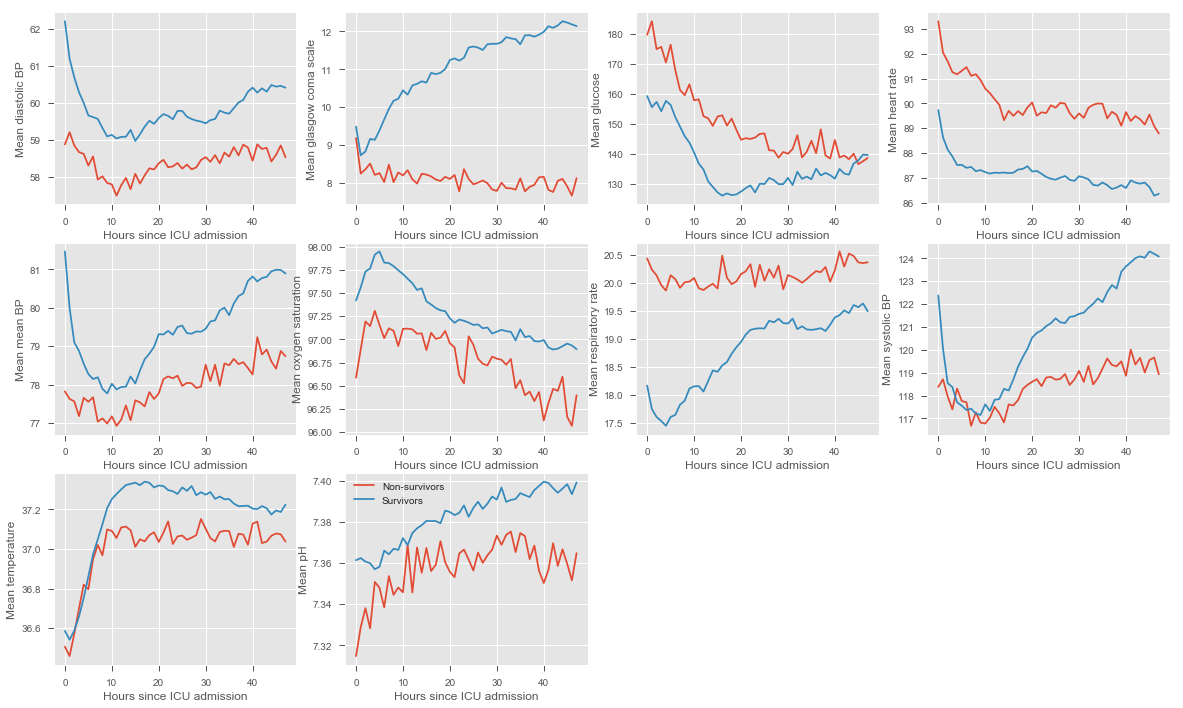

In [18]:
fig = plt.figure(figsize=(20,12))
count = 0
for variable in variables:
    count += 1
    data4clustering = timeseries_data(data_median_hour, variable, filldata = 0)
    print('Plotting ' + str(data4clustering.count().sum()) + ' observations - ' + variable)    
    class1 = data4clustering.loc[data[data['mortality']==1].index.unique()].mean()
    class0 = data4clustering.loc[data[data['mortality']==0].index.unique()].mean()
    plt.subplot(3, 4, count)
    plt.plot(class1)
    plt.plot(class0)
    plt.xlabel('Hours since ICU admission')
    plt.ylabel('Mean ' + variable)

plt.legend(['Non-survivors', 'Survivors'])    
plt.show()


The physiological deterioriation or improvement over time is very different between survival and non-survival groups. While using the pairwise plot we could not see any differences between the groups, this type of plot reveals very clear differences. Several observations can be made:

* **Diastolic BP**
    * higher in the survival group
    * rapidly decreasing during the first 10 hours, especially in the survival group, and increasing at a lower rate thereafter
    
* **Glasgow coma scale**
    * higher in the survival group, increasing over time
    * steady around 8 in the non-survival group
    * similar between both groups at admission, but diverging thereafter
    
* **Glucose**
    * decreasing over time in both groups
    
* **Heart rate**
    * lower in the survival group
    
* **Mean BP** - similar to diastolic BP

* **Oxygen saturation**
    * higher in the survival group
    * low variation from t=0 to t=48h
 
* **Respiratory rate**
    * lower in the survival group, slowly increasing over time
    * steady around 20 in the non-survival group

* **Systolic BP** - similar to diastolic and mean BP

* **Temperature**
    * low variation from t=0 to t=48h
    * slightly increasing during the first 10 hours
    
* **pH**
    * Increasing over time in both groups
    * pH < 7.35 (associated with metabolic acidosis) during the first 10 hours in the non-survival group

Most of these graphs have fairly interesting trends, but we would not consider the oxygen saturation or temperature graphs to be clinically relevant.

    
# Feature construction

The next step before ML is to extract relevant features from the time series. We could use the complete time series for ML, however, we would need to fill in missing information or again exclude either observations or variables. Also, if we were to put all time series values together, we would have $48 \text{hours}\times 11 \text{variables}=528$ features, which would make the models difficult to interpret and could lead to overfitting. There is a simpler solution, which is to use only a portion of the information available, ideally the most relevant information for the prediction task. 

Feature construction addresses the problem of finding the transformation of variables containing the greatest amount of useful information. Simple operations will be used to construct/extract important features from the time series:

* Maximum
* Minimum
* Standard deviation
* Mean

These features will summarize the worst, best, variation and average patient' condition from t=0 to t=47h. Using the 'groupby' function to aggregate data by ICU stay, together with the 'max', 'min', 'std' and 'mean' operators, these features can be easily extracted.

In [19]:
def feat_transf(data):
    data_max = data.groupby(['icustay'])[variables].max()
    data_max.columns = ['max ' + str(col) for col in data_max.columns]

    data_min = data.groupby(['icustay'])[variables].min()
    data_min.columns = ['min ' + str(col) for col in data_min.columns]
    
    data_sd = data.groupby(['icustay'])[variables].std()
    data_sd.columns = ['sd ' + str(col) for col in data_sd.columns]

    data_mean = data.groupby(['icustay'])[variables].mean()
    data_mean.columns = ['mean ' + str(col) for col in data_mean.columns]

    data_agg = pd.concat([data_min,data_max,data_sd,data_mean],axis=1)
    
    return data_agg

data_transf = feat_transf(data_median_hour).dropna(axis=0)

print('Extracted features: ')
display.display(list(data_transf.columns))
print('')
print('Number of ICU stays: ' + str(data_transf.shape[0]))
print('Number of features: ' + str(data_transf.shape[1]))
data_transf.head()

Extracted features: 


['min diastolic BP',
 'min glasgow coma scale',
 'min glucose',
 'min heart rate',
 'min mean BP',
 'min oxygen saturation',
 'min respiratory rate',
 'min systolic BP',
 'min temperature',
 'min pH',
 'max diastolic BP',
 'max glasgow coma scale',
 'max glucose',
 'max heart rate',
 'max mean BP',
 'max oxygen saturation',
 'max respiratory rate',
 'max systolic BP',
 'max temperature',
 'max pH',
 'sd diastolic BP',
 'sd glasgow coma scale',
 'sd glucose',
 'sd heart rate',
 'sd mean BP',
 'sd oxygen saturation',
 'sd respiratory rate',
 'sd systolic BP',
 'sd temperature',
 'sd pH',
 'mean diastolic BP',
 'mean glasgow coma scale',
 'mean glucose',
 'mean heart rate',
 'mean mean BP',
 'mean oxygen saturation',
 'mean respiratory rate',
 'mean systolic BP',
 'mean temperature',
 'mean pH']


Number of ICU stays: 6931
Number of features: 40


min diastolic BP  min glasgow coma scale  min glucose  \
icustay                                                           
200003.0              47.0                     5.0         90.0   
200019.0              30.0                     6.0        117.0   
200045.0              16.0                     3.0         18.0   
200059.0              52.0                    10.0        121.0   
200102.0              35.5                     3.0        117.0   

          min heart rate  min mean BP  min oxygen saturation  \
icustay                                                        
200003.0            66.0    55.000000                   91.5   
200019.0            42.0    64.333298                   95.0   
200045.0            64.0    49.333302                   90.0   
200059.0            64.5    65.000000                   93.0   
200102.0            64.0    50.000000                   88.5   

          min respiratory rate  min systolic BP  min temperature  min pH  \
icustay                                                                    
200003.0                   0.0             82.0        36.388901    7.36   
200019.0                  11.0            129.0        36.166698    7.36   
200045.0                   2.0            104.0        36.111111    7.19   
200059.0                  10.5             89.0        33.055599    7.37   
200102.0                   4.0             84.0        35.300001    7.34   

            ...     mean diastolic BP  mean glasgow coma scale  mean glucose  \
icustay     ...                                                                
200003.0    ...             61.446809                10.538462    125.750000   
200019.0    ...             48.829545                 7.769231    139.300000   
200045.0    ...             47.958333                12.000000    171.714286   
200059.0    ...             68.712766                10.250000    166.062500   
200102.0    ...             51.000000                 7.227273    174.521739   

          mean heart rate  mean mean BP  mean oxygen saturation  \
icustay                                                           
200003.0        86.744681     75.138298               96.819149   
200019.0        54.922222     88.499998               99.255556   
200045.0        87.083333     75.645842               97.512195   
200059.0        93.728261     91.553191               99.788889   
200102.0        78.156250     69.458333               95.437500   

          mean respiratory rate  mean systolic BP  mean temperature   mean pH  
icustay                                                                        
200003.0              23.130435        104.159574         37.491236  7.419444  
200019.0              20.122222        167.909091         37.310201  7.370000  
200045.0              21.936170        130.062500         36.663600  7.281429  
200059.0              14.776596        131.861702         36.375740  7.413333  
200102.0              18.687500        115.156250         36.085660  7.382222  

[5 rows x 40 columns]

A DataFrame containing one row per ICU stay was obtained, where each column corresponds to one feature. We are one step closer to building our models. Next, we are going to add the time invariant information - age and gender - to the dataset.


In [20]:
mortality = data.loc[data_transf.index]['mortality'].groupby(['icustay']).mean()
age = data.loc[data_transf.index]['age'].groupby(['icustay']).mean()
gender = data.loc[data_transf.index]['gender'].groupby(['icustay']).mean()

data_transf_inv = pd.concat([data_transf, age, gender, mortality], axis=1).dropna(axis=0)
print('Number of ICU stays: ' + str(data_transf_inv.shape[0]))
print('Number of features: ' + str(data_transf_inv.shape[1]))

Number of ICU stays: 6931
Number of features: 43


# Data partitioning

In order to assess the performance of the models, data can be divided into:

* Training set: used to train/build the learning algorithm.
* Validation (or development) set: use to tune parameters, select features, and make other decisions regarding the learning algorithm. 
* Test set: used to evaluate the performance of the algorithm, but not to make any decisions regarding what learning algorithm or parameters to use.

<img src="partitioning.png" style="width: 500px;"/>

For simplicity, data will be divided into two sets, one for training and another for testing. Later, when performing feature selection, the training set will be divided into two sets, for training and validation.

We will use the 'train_test_split' function from sklearn library, which randomly assigns observations to each set. The size of the sets can be controlled using the 'test_size' parameter, which defines the size of the test set and which in this case will be set to 20%. When using the 'train_test_split' function, it is important to set the 'random_state' parameter so that later the same results can be reproduced.


In [21]:
from sklearn.cross_validation import train_test_split

# set the % of observations in the test set
test_size = 0.2

# Divide the data intro training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_transf_inv, data_transf_inv[['mortality']], test_size = test_size, random_state = 10)
    

/Users/catiasalgado/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


It is useful to create a function that prints the size of data in each set:

In [22]:
def print_size(y_train, y_test):
    print(str(len(y_train[y_train['mortality']==1])) + '(' + str(round(len(y_train[y_train['mortality']==1])/len(y_train)*100,1)) + '%)' + ' non-survivors in training set')
    print(str(len(y_train[y_train['mortality']==0])) + '(' + str(round(len(y_train[y_train['mortality']==0])/len(y_train)*100,1)) + '%)' + ' survivors in training set')
    print(str(len(y_test[y_test['mortality']==1])) + '(' + str(round(len(y_test[y_test['mortality']==1])/len(y_test)*100,1)) + '%)' + ' non-survivors in test set')
    print(str(len(y_test[y_test['mortality']==0])) + '(' + str(round(len(y_test[y_test['mortality']==0])/len(y_test)*100,1)) + '%)' + ' survivors in test set')


In cases where the data is highly imbalanced, it might be a good option to force an oversampling of the minority class, or a undersampling of the majority class so that the model is not biased towards the majority class. This should be performed on the training set, whereas the test set should maintain the class imbalance found on the original data, so that when evaluating the final model a true representation of data is used.

For the purpose of facilitating clustering interpretability we will use undersampling, but keep in mind that as a general rule of thumb, and unless you have a huge number of observations, oversampling is preferred over undersampling because it allows keeping all the information in the training set. In any case, selecting learning algorithms that account for class imbalance might be a better choice.

The next example shows how to undersample the majority class, given a desired size of the minority class, controlled by the parameter 'perc_class1'. If 'perc_class1'>0, undersampling is performed in order to have a balanced training set. If 'perc_class1'=0, no balancing is performed.


In [23]:
# set the % of class 1 samples to be present in the training set. 
perc_class1 = 0.4

print('Before balancing')
print_size(y_train, y_test)
        
if perc_class1 > 0:
        
    # Find the indices of class 0 and class 1 samples
    class0_indices = y_train[y_train['mortality'] == 0].index
    class1_indices = y_train[y_train['mortality'] == 1].index

    # Calculate the number of samples for the majority class (survivors)
    class0_size = round(np.int((len(y_train[y_train['mortality'] == 1])*(1 - perc_class1)) / perc_class1),0)
    
    # Set the random seed generator for reproducibility
    np.random.seed(10)
        
    # Random sample majority class indices
    random_indices = np.random.choice(class0_indices, class0_size, replace=False)    
        
    # Concat class 0 with class 1 indices
    X_train = pd.concat([X_train.loc[random_indices],X_train.loc[class1_indices]])
    y_train = pd.concat([y_train.loc[random_indices],y_train.loc[class1_indices]])

    print('After balancing')
    print_size(y_train, y_test)
            
# Exclude output from input data
X_train = X_train.drop(columns = 'mortality')
X_test = X_test.drop(columns = 'mortality')
    


Before balancing
941(17.0%) non-survivors in training set
4603(83.0%) survivors in training set
246(17.7%) non-survivors in test set
1141(82.3%) survivors in test set
After balancing
941(40.0%) non-survivors in training set
1411(60.0%) survivors in training set
246(17.7%) non-survivors in test set
1141(82.3%) survivors in test set


# Clustering

Clustering is a learning task that aims at decomposing a given set of observations into subgroups (clusters), based on data similarity, such that observations in the same cluster are more closely related to each other than observations in different clusters. It is an unsupervised learning task, since it identifies structures in unlabeled datasets, and a classification task, since it can give a label to observations according to the cluster they are assigned to.

This chapter focuses on the following questions:

* Can we identify distinct patterns even if the class labels are not provided? 

* How are the different patterns represented across different outcomes?

In order to address these questions, we will start by providing a description of the basic concepts underlying k-means clustering, show how the algorithm works using 2D data as an example, perform clustering of time series and use the information gained with clustering to train predictive models.


## K-means clustering algorithm

Consider a (training) dataset composed of $N$ observations:

$$
\begin{aligned}
x_1, x_2,..., x_N
\end{aligned}
$$

Initialize K centroids $\mu_1, \mu_2, ..., \mu_K$ randomly.

Repeat until convergence:

1. Cluster assignment <br>

    Assign each $x_i$ to the nearest cluster.<br>
    For every $i$ do: <br>
$$
\begin{aligned}
\underset{j}{argmin}\left \| x_i-\mu_j \right \|^2,
\end{aligned}
$$
    where $j=1,2,...,K$

2. Cluster updating <br>

    Update the cluster centroids $\mu_j$.<br>
    For every $j$ do:
$$
\begin{aligned}
\mu_j = \frac{1}{N_j}\left [ x_1^j + x_2^j + ... + x_{N_j}^j \right ],
\end{aligned}
$$
    where $N_j$ is the number of observations assigned to cluster $j$, $k=1,2, ..., N_j$, and $x_k^j$ represents observation $k$ assigned to cluster $j$. <br>
    Each new centroid corresponds the mean of the observations assigned in the previous step.

## Exemplification with 2D data

Although pairwise plots did not reveal any interesting patterns, some clusters might have emerged after the data were transformed. You can re-run the code for pairwise plots between transformed features, but note that it will be time consuming due to the high dimensionality of the dataset. Features 'max mean BP' and 'mean heart rate' were chosen for illustrative purposes. The dataset is plotted below:


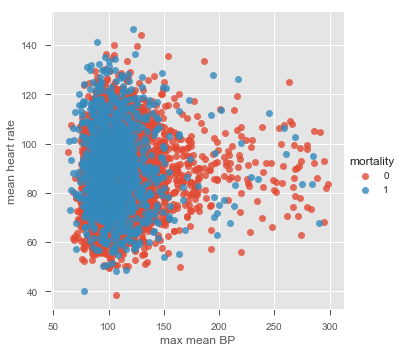

In [24]:
x1 = 'max mean BP'
x2 = 'mean heart rate'
sns.lmplot(x1, x2, data_transf_inv, hue="mortality", fit_reg=False);

The number of clusters (K) must be provided before running K-means. It is not easy to guess the number of clusters just by looking at the previous plot, but for the purpose of understanding how the algorithm works we will use 3 clusters. As usual, the 'random_state' parameter is predefined. It does not matter which value is defined; the important thing is that this way we garantee that when using the predefined value we will always get the same results.

The next example shows how to perform K-means using sklearn.

In [25]:
from sklearn.cluster import KMeans

# set the number of clusters
K = 3

# input data to fit K-means
X = pd.DataFrame.as_matrix(data_transf_inv[[x1,x2]])

# fit kmeans
kmeans = KMeans(n_clusters=K, random_state=0).fit(data_transf_inv[[x1,x2]])
    

The attribute 'labels_' gives the cluster labels, indicating to which cluster each observation belongs, and 'cluster_centers_' gives the coordinates of cluster centers, representing the mean of all observations in the cluster. Using these two attributes it is possible to plot the clusters centers and the data in each cluster using different colors do distinguish the clusters:

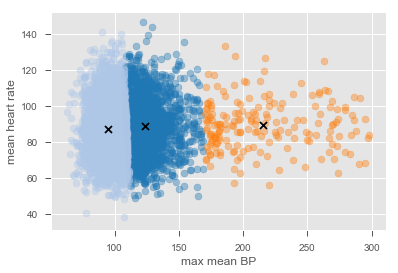

In [26]:
classes = kmeans.labels_
centroids = kmeans.cluster_centers_

# define a colormap
colormap = plt.get_cmap('tab20')
for c in range(K):
    centroids[c] = np.mean(X[classes == c], 0)
    plt.scatter(x = X[classes == c,0], y = X[classes == c,1], alpha = 0.4, c = colormap(c))
    plt.scatter(x = centroids[c,0], y = centroids[c,1], c = 'black', marker='x')
        
plt.xlabel(x1)
plt.ylabel(x2)
display.clear_output(wait=True)

The algorithm is simple enough to be implemented using a few lines of code. If you want to see how the centers converge after a number of iterations, you can use the code below which is an implementation of the k-means clustering algorithm step by step.

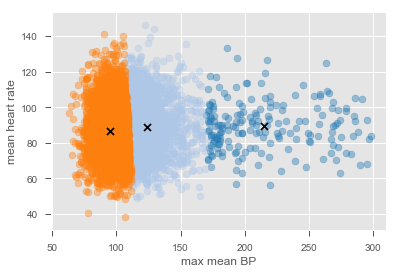

In [27]:
# The following code was adapted from http://jonchar.net/notebooks/k-means/
import time
from IPython import display

K = 3

def initialize_clusters(points, k):
    """Initializes clusters as k randomly selected coordinates."""
    return points[np.random.randint(points.shape[0], size=k)]
    
def get_distances(centroid, points):
    """Returns the distance between centroids and observations."""
    return np.linalg.norm(points - centroid, axis=1)

# Initialize centroids
centroids = initialize_clusters(X, K)
centroids_old = np.zeros([K, X.shape[1]], dtype=np.float64)

# Initialize the vectors in which the assigned classes
# of each observation will be stored and the
# calculated distances from each centroid
classes = np.zeros(X.shape[0], dtype=np.float64)
distances = np.zeros([X.shape[0], K], dtype=np.float64)

# Loop until convergence of centroids
error = 1
while error>0:
    
    # Assign all observations to the nearest centroid
    for i, c in enumerate(centroids):
        distances[:, i] = get_distances(c, X)
        
    # Determine class membership of each observation
    # by picking the closest centroid
    classes = np.argmin(distances, axis=1)
    
    # Update centroid location using the newly
    # assigned observations classes
    # Change to median in order to have k-medoids
    for c in range(K):
        centroids[c] = np.mean(X[classes == c], 0)
        plt.scatter(x = X[classes == c,0], y = X[classes == c,1], alpha = 0.4, c = colormap(c))
        plt.scatter(x = centroids[c,0], y = centroids[c,1], c = 'black', marker='x')

    error = sum(get_distances(centroids, centroids_old))
    centroids_old = centroids.copy() 

    #pl.text(max1, min2, str(error))
    plt.xlabel(x1)
    plt.ylabel(x2)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    # decrease the step to make it faster
    time.sleep(0.1)
    
    plt.gcf().clear()


The animation shows the position of the cluster centers at each iteration, until convergence to the final centroids. Note that the trajectory of the centers depends on the cluster initialization; because the initialization is random, the centers might not always converge to the same position.

## Time series clustering 

Time series analysis revealed distinct and interesting patterns across survivors and non-survivors. Next, K-means clustering will be used to investigate patterns in time series. The goal is to stratify patients according to their evolution in the ICU, from admission to t = 48 hours, for every variable separately. Note that at this point we are back working with time series information instead of constructed features.

For this particular task and type of algorithm, it is important to normalize data for each patient separately. This will allow a comparison between time trends rather than a comparison between the magnitude of observations. In particular, if the data is normalized individually for each patient, clustering will tend to group together patients that (for example) started with the lowest values and ended up with the highest values, whereas if the data is not normalized, the same patients might end up in different clusters because of the magnitude of the signal, even though the trend is similar. 

Missing data is filled forward, i.e., missing values are replaced with the value preceding it (the last known value at any point in time). If there is no information preceding a missing value, these are replaced by the following values.

In [28]:
# Now we are going to pivot the table in order to have rows corresponding to unique 
# ICU stays and columns corresponding to hour since admission. This will be used for clustering 

def clustering(variable, ids_clustering, K, *args):
    """Return data for clustering, labels attributted to training observations and 
    if *args is provided return labels attributted to test observations"""
    
    data4clustering = timeseries_data(data_median_hour, variable, filldata = 1)
        
    # data for clustering is normalized by patient
    # since the data is normalized by patient we can normalize training and test data together
    for index, row in data4clustering.iterrows():
        maxx = data4clustering.loc[index].max()
        minn = data4clustering.loc[index].min()
        data4clustering.loc[index] = (data4clustering.loc[index] - minn) / (maxx-minn)
    
    # select data for creating the clusters
    data4clustering_train = data4clustering.loc[ids_clustering].dropna(axis=0)
    print('Using ' + str(data4clustering_train.shape[0]) + ' ICU stays for creating the clusters')
    
    # create the clusters
    kmeans = KMeans(n_clusters = K, random_state = 2).fit(data4clustering_train)
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    # test the clusters if test data is provided
    labels_test = []
    for arg in args:
        data4clustering_test = data4clustering.loc[arg].set_index(arg).dropna(axis=0)
        labels_test = kmeans.predict(data4clustering_test)
        labels_test = pd.DataFrame(labels_test).set_index(data4clustering_test.index)
        print('Using ' + str(data4clustering_test.shape[0]) + ' ICU stays for cluster assignment')
 
    # this is all printing and plotting
    print(str(K) + ' clusters')
    cluster=0
    d = {}
    mortality_cluster = {}
    
    colormap1 = plt.get_cmap('jet')
    colors = colormap1(np.linspace(0,1,K))
    
    fig1 = plt.figure(1, figsize=(15,4))
    fig2 = plt.figure(2, figsize=(15,3))
            
    for center in centers: 
        ax1 = fig1.add_subplot(1,2,1)
        ax1.plot(center, color = colors[cluster])
        
        ax2 = fig2.add_subplot(1,K,cluster+1)
        data_cluster =  data4clustering_train.iloc[labels==cluster]
        ax2.plot(data_cluster.transpose(),  alpha = 0.1, color = 'silver')
        ax2.plot(center, color = colors[cluster])
        ax2.set_xlabel('Hours since admission')        
        if cluster == 0:
            ax2.set_ylabel('Normalized ' + variable)   
        ax2.set_ylim((0, 1))
        cluster += 1
        data_cluster_mort = data['mortality'].loc[data_cluster.index].groupby(['icustay']).mean()
        print('Cluster ' + str(cluster) + ': ' + str(data_cluster.shape[0]) + ' observations')
        mortality_cluster[cluster] = sum(data_cluster_mort)/len(data_cluster_mort)*100
        d[cluster] = str(cluster)
         
    labels = pd.DataFrame(labels).set_index(data4clustering_train.index)
    
    ax1.legend(d)
    ax1.set_xlabel('Hours since ICU admission')
    ax1.set_ylabel('Normalized ' + variable)
    ax1.set_ylim((0, 1))
    
    ax3 = fig1.add_subplot(1,2,2)
    x, y = zip(*mortality_cluster.items()) 
    ax3.bar(x, y, color=colors)
    ax3.set_xlabel('Cluster')
    ax3.set_ylabel('Non-survivors (%)')    
    ax3.set_xticks(np.arange(1, K+1, step=1))
    
    plt.show()
    
    if args:
        return data4clustering, labels, labels_test
    else:
        return data4clustering, labels

### Visual inspection of the best number of clusters for each variable 

In the next example, K-means clustering is performed for glasgow coma scale (GCS), for a varying number of clusters (K). Only the training data is used to identify the clusters. The figures show, by order of appearance:

* Fig. 1: cluster centers;
* Fig. 2: percentage of non-survivors in each cluster;
* Fig. 3+: cluster centers and training data in each cluster. 


Using 2139 ICU stays for creating the clusters
5 clusters
Cluster 1: 337 observations
Cluster 2: 481 observations
Cluster 3: 333 observations
Cluster 4: 519 observations
Cluster 5: 469 observations


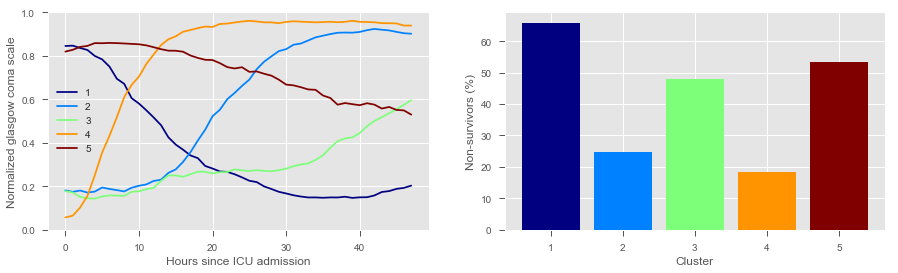

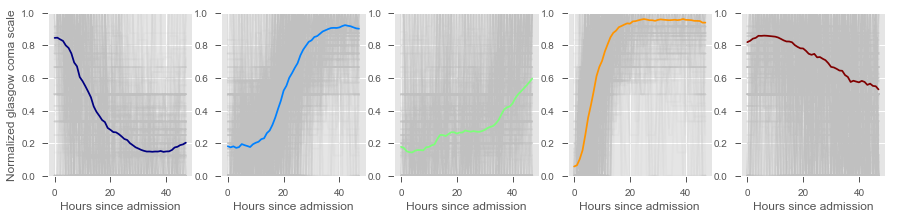

In [29]:
variable = 'glasgow coma scale'
clusters = range(5, 6)

ids_clustering = X_train.index.unique()
for K in clusters:
    data4clustering, cluster_labels = clustering(variable, ids_clustering, K)
    

The goal of plotting cluster centers, mortality distribution and data in each cluster is to visually inspect the quality of the clusters. Another option would be to use quantitative methods, typically known as cluster validity indices, that automatically give the "best" number of clusters according to some criteria (e.g., cluster compacteness, cluster separation). Some interesting findings are:

* $K = 2$
    * shows two very distinct patterns, similar to what was found by partitioning by mortality;
    * but, we probably want more stratification;
* $K = 3$
    * 2 groups where GCS is improving with time;
    * 1 group where GCS is deteriorating;
    * yes, this is reflected in terms of our ground truth labels, even though we did not provide that information to the clustering. Mortality$>60\%$ in one cluster vs $30\%$ and $28\%$ in the other two clusters;
* $K = 4$
    * one more "bad" cluster appears;
* $K = 5$
    * 2 clusters have similar patterns and low mortality. GCS is increasing/improving with time;
    * 3 clusters have high mortality. In 2 of them GCS is decreasing/deteriorating with time;
    * 1 cluster is the "worst" cluster. Mortality is close to $70\%$.

In summary, every $K$ from 2 to 5 gives an interesting view of the evolution of GCS and its relation with mortality. For the sake of simplicity, this analysis is only shown for GCS. You can investigate on your own the cluster tendency for other variables and decide what is a good number of clusters for all of them. For now, the following K will be used for each variable:


In [30]:
# create a dictionary of selected K for each variable
Ks = dict([('diastolic BP', 4), 
           ('glasgow coma scale', 4),
           ('glucose', 5),
           ('heart rate', 5),
           ('mean BP', 5),
           ('oxygen saturation', 3),
           ('respiratory rate', 5),
           ('systolic BP', 4),
           ('temperature', 4),
           ('pH', 4),
          ])

Cluster labels will be used to add another layer of information to the machine learning models.

### Training and testing

K-means training and testing phases can be described as:

* Training phase: perform clustering using the traininig data. Cluster centers will be created and training observations, used to create the clusters, are assigned to each cluster;

* Test phase: assign new observations to one of the clusters defined in the training phase. Each observation is assigned to the most similar cluster, i.e., to the cluster whose center is at a smaller distance. These observations were not used to identify clusters centers.

The next example trains/creates and tests/assigns clusters using the 'clustering' function previously defined. Cluster labels are stored in 'cluster_labels_train' and 'cluster_labels_test'.

diastolic BP
Using 2352 ICU stays for creating the clusters
Using 1387 ICU stays for cluster assignment
4 clusters
Cluster 1: 633 observations
Cluster 2: 414 observations
Cluster 3: 658 observations
Cluster 4: 647 observations


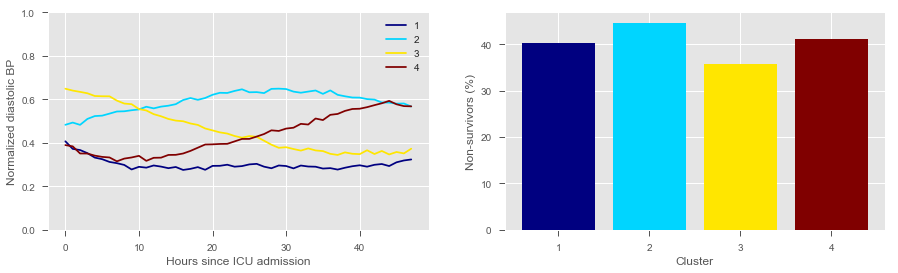

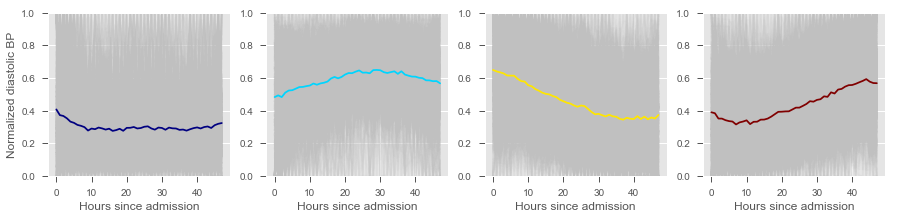

glasgow coma scale
Using 2139 ICU stays for creating the clusters
Using 1251 ICU stays for cluster assignment
4 clusters
Cluster 1: 585 observations
Cluster 2: 589 observations
Cluster 3: 461 observations
Cluster 4: 504 observations


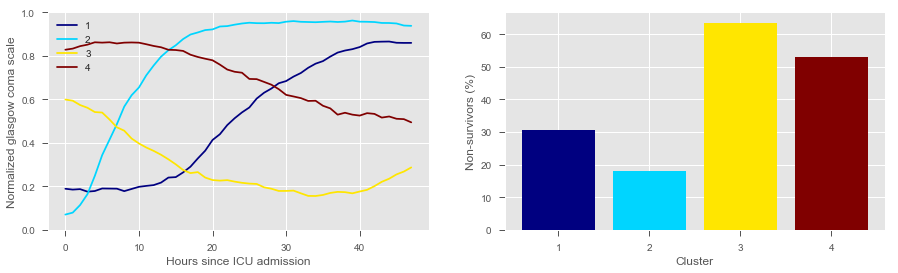

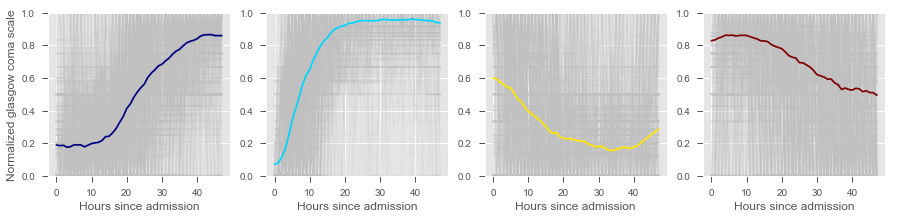

glucose
Using 2351 ICU stays for creating the clusters
Using 1387 ICU stays for cluster assignment
5 clusters
Cluster 1: 362 observations
Cluster 2: 716 observations
Cluster 3: 431 observations
Cluster 4: 398 observations
Cluster 5: 444 observations


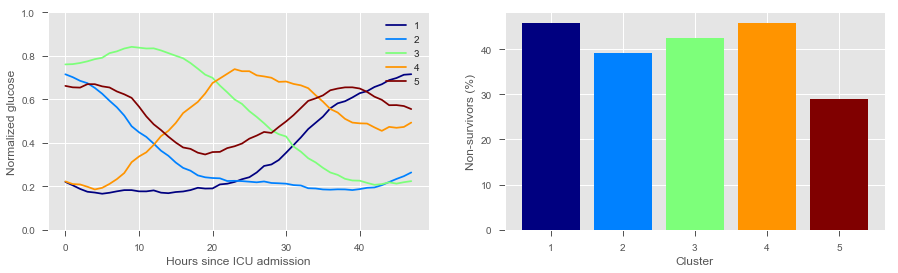

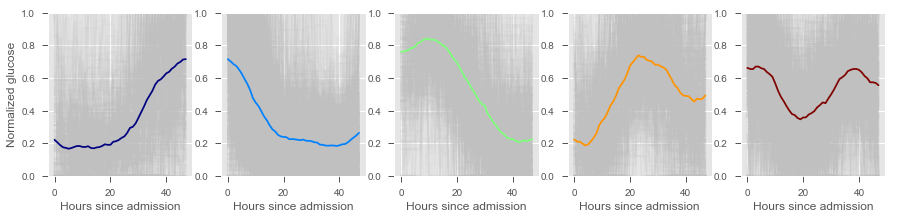

heart rate
Using 2350 ICU stays for creating the clusters
Using 1387 ICU stays for cluster assignment
5 clusters
Cluster 1: 455 observations
Cluster 2: 455 observations
Cluster 3: 452 observations
Cluster 4: 482 observations
Cluster 5: 506 observations


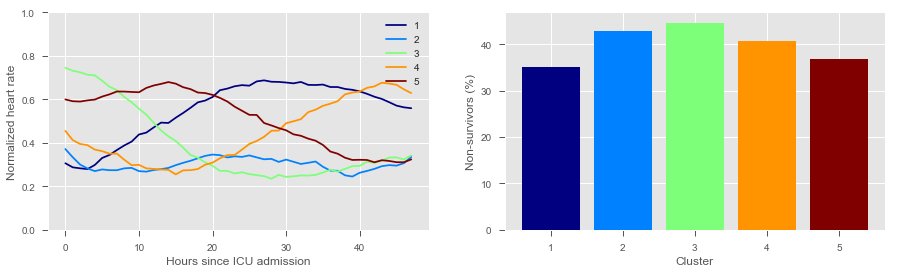

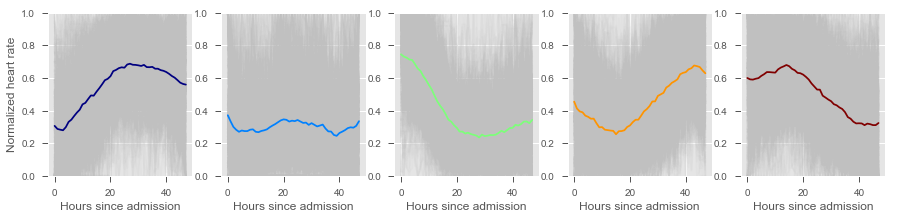

mean BP
Using 2352 ICU stays for creating the clusters
Using 1387 ICU stays for cluster assignment
5 clusters
Cluster 1: 505 observations
Cluster 2: 499 observations
Cluster 3: 526 observations
Cluster 4: 381 observations
Cluster 5: 441 observations


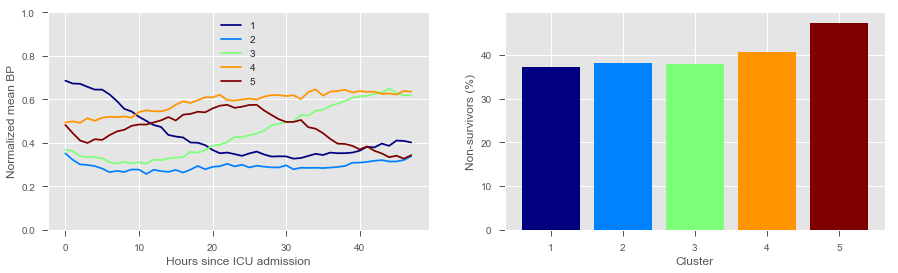

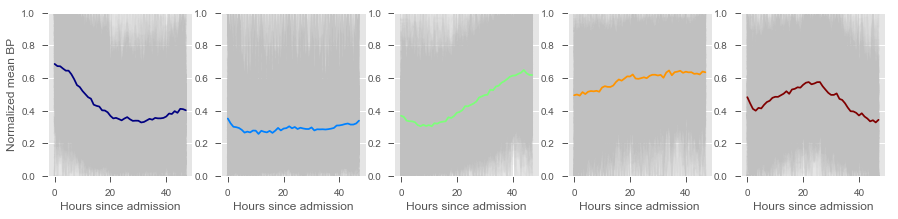

oxygen saturation
Using 2344 ICU stays for creating the clusters
Using 1378 ICU stays for cluster assignment
3 clusters
Cluster 1: 466 observations
Cluster 2: 1143 observations
Cluster 3: 735 observations


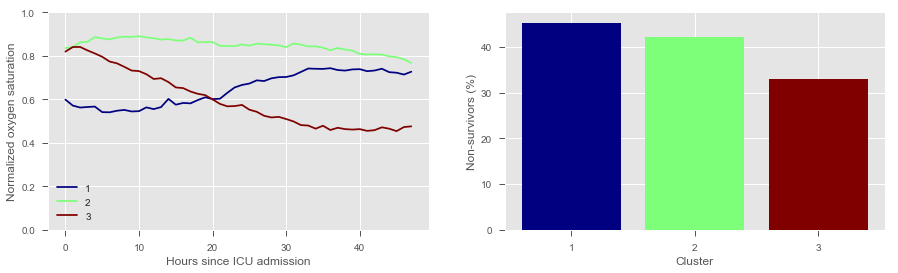

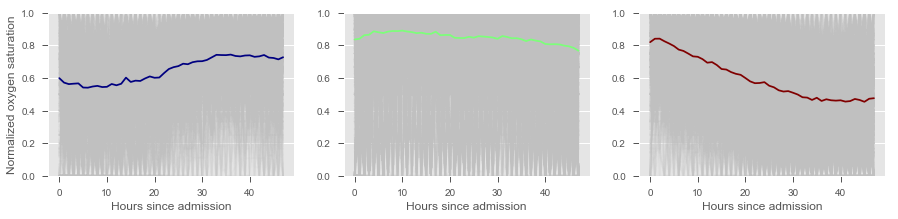

respiratory rate
Using 2352 ICU stays for creating the clusters
Using 1387 ICU stays for cluster assignment
5 clusters
Cluster 1: 385 observations
Cluster 2: 500 observations
Cluster 3: 516 observations
Cluster 4: 468 observations
Cluster 5: 483 observations


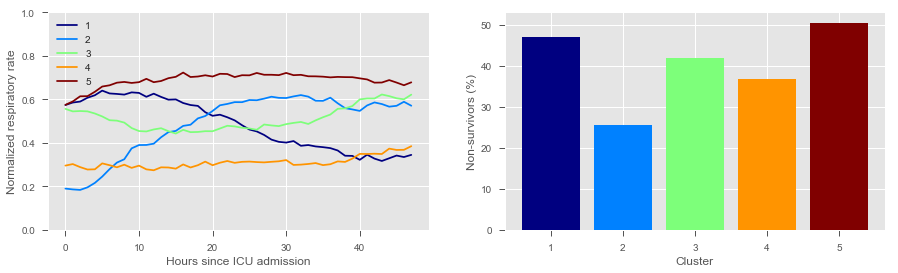

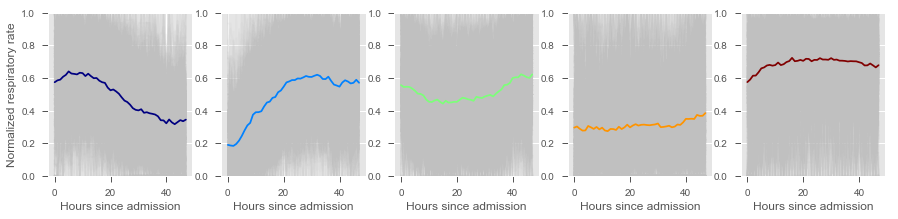

systolic BP
Using 2352 ICU stays for creating the clusters
Using 1387 ICU stays for cluster assignment
4 clusters
Cluster 1: 653 observations
Cluster 2: 586 observations
Cluster 3: 574 observations
Cluster 4: 539 observations


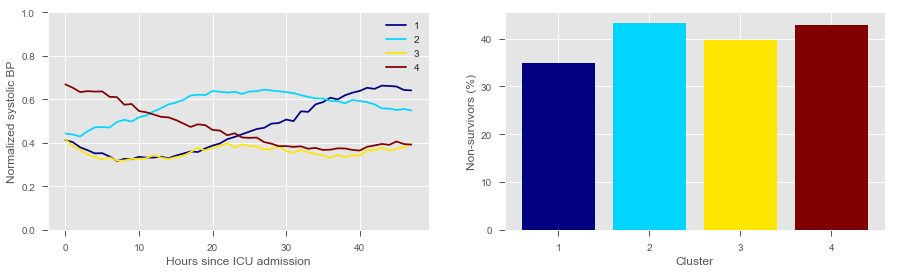

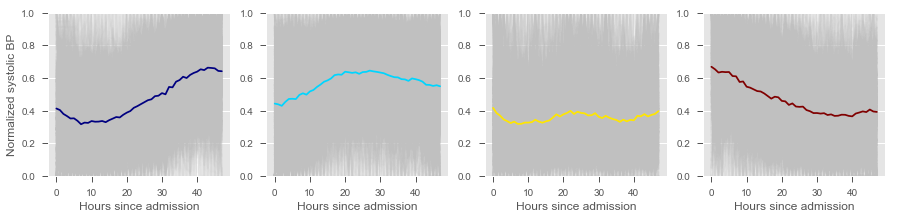

temperature
Using 2352 ICU stays for creating the clusters
Using 1387 ICU stays for cluster assignment
4 clusters
Cluster 1: 472 observations
Cluster 2: 695 observations
Cluster 3: 561 observations
Cluster 4: 624 observations


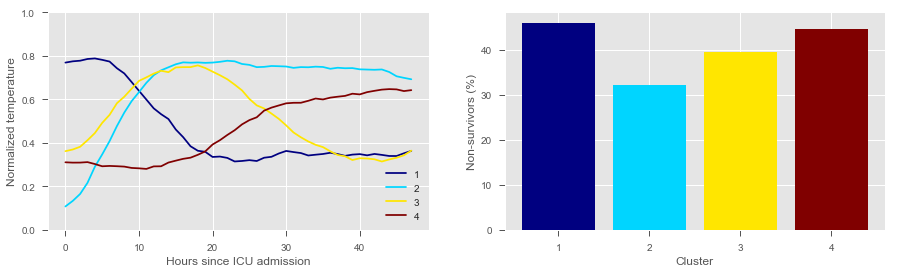

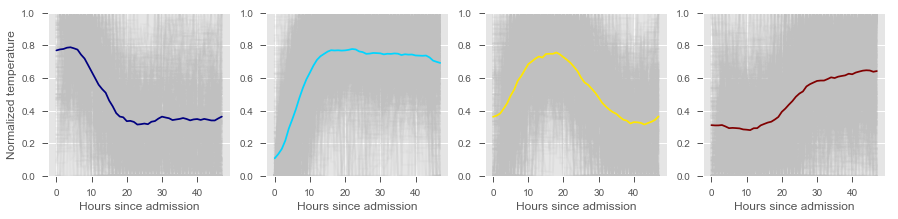

pH
Using 2326 ICU stays for creating the clusters
Using 1363 ICU stays for cluster assignment
4 clusters
Cluster 1: 472 observations
Cluster 2: 789 observations
Cluster 3: 643 observations
Cluster 4: 422 observations


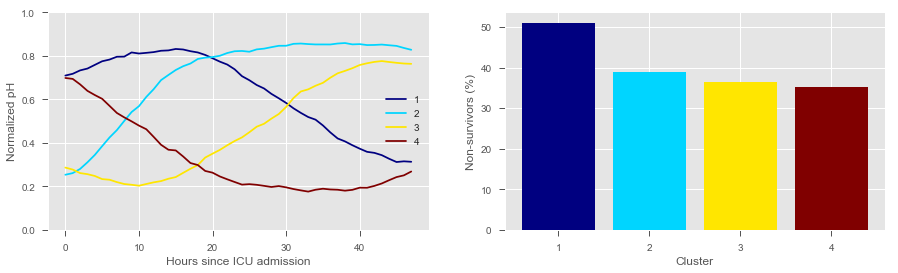

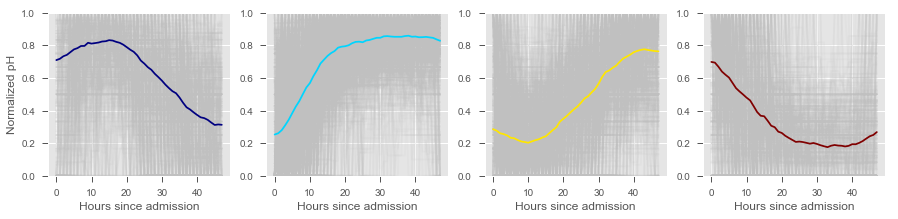

In [31]:
id_train = X_train.index.unique()
id_test = X_test.index.unique()
cluster_labels_train = pd.DataFrame()
cluster_labels_test = pd.DataFrame()

for feature in variables:
    print(feature)
    K = Ks[feature]
    data4clustering, labels_train, labels_test = clustering(feature, id_train, K, id_test)

    labels_test.columns=['CL ' + feature]
    labels_train.columns=['CL ' + feature]
    
    cluster_labels_train = pd.concat([cluster_labels_train, labels_train], axis=1).dropna(axis=0)
    cluster_labels_test = pd.concat([cluster_labels_test, labels_test], axis=1).dropna(axis=0)


for col in cluster_labels_train:
    cluster_labels_train[col] = cluster_labels_train[col].astype('category')

for col in cluster_labels_test:
    cluster_labels_test[col] = cluster_labels_test[col].astype('category')
    

Clustering allowed us to stratify patients according to their physiological evolution over 48 hours. Since cluster centers reflect the cluster tendency, it is possible to investigate the relation between distinct physiological patterns and mortality, and ascertain if the relation is expected.

For example, cluster 4 and cluster 5 in glucose are more or less symmetric: in cluster 4, patients start with low glucose, which increases over time until it decreases again; in cluster 5, patients start with high glucose, which decreases over time until it increases again. In the first case, mortality is approximately $45\%$ and in the second case it is approximately $30\%$. Although this is obviously not enough to predict mortality, it highlights a possible relationship between the evolution of glucose and mortality. If a certain patient has a pattern of glucose similar to cluster 4, there may be more reason for concern than if he/she expresses the pattern in cluster 5.

By now, some particularities of the type of normalization performed can be noted:

* It hinders interpretability;
* It allows the algorithm to group together patients that did not present significant changes in their physiological state through time, regardless of the absolute value of the observations. 

We have seen how clustering can be used to stratify patients, but not how it can be used to predict outcomes. Predictive models that use the information provived by clustering will be investigated next. Models will be created for the extracted features together with cluster information.

## Normalization

Normalization, or scaling, is used to ensure that all features lie between a given minimum and maximum value, often between zero and one. The maximum and mininum values of each feature should be determined during the training phase and the same values should be applied during the test phase.

The next example is used to normalize the features extracted from the time series according to

$x_{norm} = \frac{x-min(x)}{max(x) - min(x)}$


In [32]:
X_train_min = X_train.min()
X_train_max = X_train.max()
X_train_norm = (X_train - X_train_min) / (X_train_max - X_train_min)
X_test_norm = (X_test - X_train_min) / (X_train_max - X_train_min)

Note that:

* The data is normalized for the entire dataset at once, and not for each patient individually as in the clustering step;

* Normalization is useful when solving for example least squares or functions involving the calculation of distances. Normalization does not impact the performance of a decision tree. 

The next example uses the 'preprocessing' package from 'sklearn' which does exactly the same:


In [33]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_train_norm_skl = pd.DataFrame(min_max_scaler.fit_transform(X_train))

# The same instance of the transformer can be applied to new test data unseen during the fit call:
# the same scaling and shifting operations will be applied to be consistent with the transformation performed on the train data.
X_test_norm_skl = pd.DataFrame(min_max_scaler.transform(X_test))


## Concatenate predicted clustering labels with extracted features

The 'get_dummies' function from 'pandas' will be used to get dummy variables for the cluster labels obtained through k-means. The idea is to use binary cluster labels, i.e., features indicating "yes/no belongs to cluster k", as input to the models. This will give an extra level of information regarding the clinical temporal evolution of the patient in a multidmensional space.

You can add a 'drop_first' parameter to the 'get_dummies' function to indicate if you want to exclude one category, i.e., whether to get k-1 dummies out of k categorical levels by removing the first level. 

In [34]:
# drop_first : bool, default False
# use drop_first=True to exclude one of the categories

X_train_clust = pd.get_dummies(cluster_labels_train, prefix_sep=' ')
y_train_clust = pd.DataFrame(data_transf_inv.loc[cluster_labels_train.index]['mortality'])
X_test_clust = pd.get_dummies(cluster_labels_test, prefix_sep=' ')
y_test_clust = pd.DataFrame(data_transf_inv.loc[cluster_labels_test.index]['mortality'])

X_train = pd.concat([X_train_norm, X_train_clust], axis=1).dropna(axis=0)
y_train = y_train.loc[X_train.index]

X_test = pd.concat([X_test_norm, X_test_clust], axis=1).dropna(axis=0)
y_test = y_test.loc[X_test.index]


Let us print the number of observations in the training and test sets, total number of features and a snapshot of the data.

In [35]:
print('Number of observations in training set: ' + str(X_train.shape[0]))
print('Number of observations in test set: ' + str(X_test.shape[0]))
print('Number of features: ' + str(X_train.shape[1]))
display.display(X_train.head())


Number of observations in training set: 2110
Number of observations in test set: 1232
Number of features: 85


min diastolic BP  min glasgow coma scale  min glucose  \
icustay                                                           
200019.0          0.370370                0.250000     0.461864   
200220.0          0.506173                0.250000     0.559322   
200250.0          0.506173                0.333333     0.387712   
200379.0          0.395062                0.000000     0.368644   
200488.0          0.617284                0.500000     0.283898   

          min heart rate  min mean BP  min oxygen saturation  \
icustay                                                        
200019.0        0.347107     0.630719                  0.950   
200220.0        0.752066     0.705882                  0.970   
200250.0        0.685950     0.552287                  0.960   
200379.0        0.570248     0.513072                  0.930   
200488.0        0.561983     0.637255                  0.895   

          min respiratory rate  min systolic BP  min temperature    min pH  \
icustay                                                                      
200019.0              0.366667         0.877551         0.760278  0.746479   
200220.0              0.300000         0.761905         0.643836  0.563380   
200250.0              0.016667         0.591837         0.739726  0.732394   
200379.0              0.300000         0.605442         0.760278  0.788732   
200488.0              0.100000         0.605442         0.842466  0.845070   

            ...      CL systolic BP 2.0  CL systolic BP 3.0  \
icustay     ...                                               
200019.0    ...                     0.0                 1.0   
200220.0    ...                     1.0                 0.0   
200250.0    ...                     1.0                 0.0   
200379.0    ...                     0.0                 1.0   
200488.0    ...                     0.0                 1.0   

          CL temperature 0.0  CL temperature 1.0  CL temperature 2.0  \
icustay                                                                
200019.0                 1.0                 0.0                 0.0   
200220.0                 1.0                 0.0                 0.0   
200250.0                 0.0                 0.0                 0.0   
200379.0                 0.0                 0.0                 1.0   
200488.0                 0.0                 0.0                 1.0   

          CL temperature 3.0  CL pH 0.0  CL pH 1.0  CL pH 2.0  CL pH 3.0  
icustay                                                                   
200019.0                 0.0        0.0        0.0        0.0        1.0  
200220.0                 0.0        0.0        0.0        1.0        0.0  
200250.0                 1.0        1.0        0.0        0.0        0.0  
200379.0                 0.0        0.0        0.0        1.0        0.0  
200488.0                 0.0        0.0        0.0        1.0        0.0  

[5 rows x 85 columns]

Note that 'CL 0.0' corresponds to cluster 1, 'CL 1.0' to cluster 2 and so on.

# Machine learning

The next section focuses on building mortality prediction models/classifiers using common algorithms and the 'sklearn' library, in particular k-Nearest neighbors, logistic regression, decision trees and random forest. Before starting, it is important to define what measures should be used to evaluate the performance of the classifiers. 

## Definition of performance measures

Having a single-number evaluation metric is useful for comparing the performance of different models. Accuracy can be misleading when classes are imbalanced. Sensitivity (also called recall or true positive rate) is a useful measure that indicates the percentage of non-survivors who are correctly identified as such. In the context of our problem, having a high sensitivity is very important, since it tells us the algorithm is able to correctly identify the most critical cases. However, optimizing for sensitivity alone may lead to the presence of many false alarms (false positives). Therefore, it is important to also have in mind specificity, which tells us the the percentage of survivors who are correctly identified as such.

* Sensitivity = $\frac{TP}{TP + FN}$
* Specificity = $\frac{TN}{TN + FP}$

One way of combining sensitivity and specificity in one measure is using the area under the receiver–operator characteristics (ROC) curve (AUC), which is a graphical plot that illustrates the performance of a binary classifier as its discrimination threshold is varied. 

The following function shows how to calculate the number of true positives, true negatives, false positives, false negatives, accuracy, sensitivity, specificity and AUC using the 'metrics' and 'confusion_matrix' packages from 'sklearn'; how to plot the ROC curve and how to choose a threshold in order to convert a continuous-value output into a binary classification.

In [36]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

def performance(y, y_pred, print_ = 1, *args):   
    """ Calculate performance measures for a given ground truth classification y and predicted 
    probabilities y_pred. If *args is provided a predifined threshold is used to calculate the performance.
    If not, the threshold giving the best mean sensitivity and specificity is selected. The AUC is calculated
    for a range of thresholds using the metrics package from sklearn. """

    # xx and yy values for ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred, pos_label=1)
    # area under the ROC curve
    AUC = metrics.auc(fpr, tpr)

    if args:
        threshold = args[0]
    else:
        # we will choose the threshold that gives the best balance between sensitivity and specificity
        difference = abs((1-fpr) - tpr)
        threshold = thresholds[difference.argmin()]        
        
    # transform the predicted probability into a binary classification
    y_pred[y_pred >= threshold] = 1
    y_pred[y_pred < threshold] = 0
    
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    # print the performance and plot the ROC curve    
    if print_ == 1:
        print('Threshold: ' + str(round(threshold,2)))
        print('TP: ' + str(tp))
        print('TN: ' + str(tn))
        print('FP: ' + str(fp))
        print('FN: ' + str(fn))
        print("Accuracy: " + str( round(accuracy, 2 )))
        print('Sensitivity: ' + str(round(sensitivity,2)))
        print('Specificity: ' + str(round(specificity,2)))                
        print('AUC: ' + str(round(AUC,2)))
    
        plt.figure(figsize = (4,3))
        plt.scatter(x = fpr, y = tpr, label = None)
        plt.plot(fpr, tpr, label = 'Classifier', zorder = 1)
        plt.plot([0, 1], [0, 1], 'k--', label = 'Random classifier')
        plt.scatter(x = 1 - specificity, y = sensitivity, c = 'black', label = 'Operating point', zorder = 2)
        plt.legend()
        plt.xlabel('1 - specificity')
        plt.ylabel('sensitivity')
        plt.show()
        

    return threshold, AUC, sensitivity, specificity


When starting a machine learning project it is always a good approach to start with a very simple model. The simple model will give a sense of how challenging the question is. The first simple model used in this chapter is logistic regression (LR). 

## Logistic regression

LR is considered a simple model especially because it is easy to understand the math behind it, making it also easy to interpret the model parameters and results, and it takes little time computing compared to other ML models.

### Feature selection

In order to reduce multicollinearity, and because we are interested in increasing the interpretability and simplicity of our model, feature selection is highly recommended. Multicollinearity exists when two or more of the predictors in a regression model are moderately or highly correlated. The problem with multicollinearity is that it makes some variables statistically insignificant when they are not necessarily so, because the estimated coefficient of one variable depends on which colinear variables are included in the model. High multicollinearity increases the variance of the regression coefficients, making them unstable, but a little bit of multicollinearity isn't necessarily a problem. As you will see, the algorithm used for feature selection does not directly addresses multicollinearity, but indirectly helps reducing it by reducing the size of the feature space. 

#### Sequential forward selection / forward stepwise selection

The sequential forward selection (SFS) algorithm is an iterative process where the subset of features that best predicts the output is obtained by sequentially selecting features until there is no improvement in prediction. The criterion used to select features and to determine when to stop is chosen based on the objectives of the problem. In this work, the criterion maximization of average sensitivity and specificity will be used.

In the first iteration, models with one feature are created (univariable analysis). The model giving the higher average sensitivity and specificity in the validation set is selected. In the second iteration, the remaining features are evaluated again one at a time, together with the feature selected in the previous iteration. This process continues until there is no significant improvement in performance. 
In order to evaluate different feature sets, the training data is divided into two sets, one for training and another for validation. This can be easily achieved using the 'train_test_split' as before:


In [37]:
val_size = 0.4
X_train_SFS, X_val_SFS, y_train_SFS, y_val_SFS = train_test_split(X_train, y_train, test_size = val_size, random_state = 10)
    

Since there is no SFS implementation in python, the algorithm is implemented from scratch. In the next example, a minimum improvement of 0.0005 will be used in order to visualize the algorithm for a few iterations. The figure shows the performance associated with each feature at each iteration of the algorithm. Different iterations have different colors and at each iteration one feature is selected and marked with a red dot. Note that this operation will take some time. You can decrease the 'min_improv' to visualize the algorithm for fewer iterations or increase it to allow more features to be added to the final set.


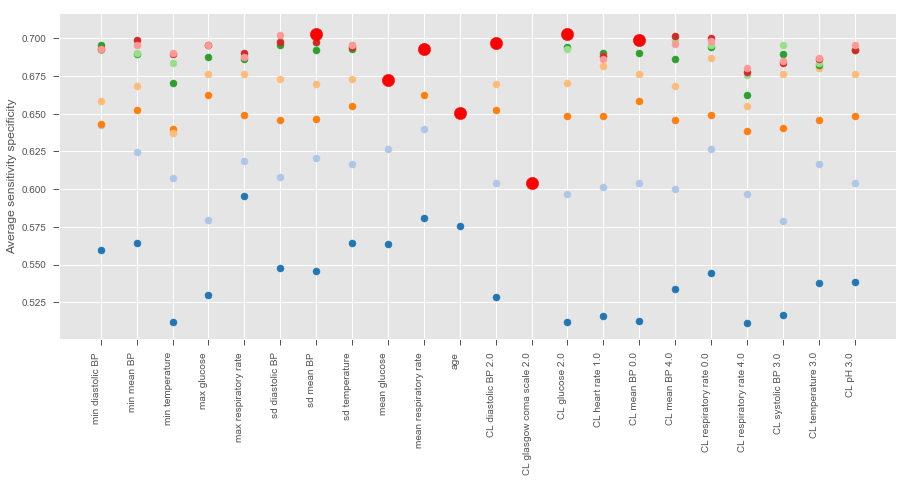

In [38]:
from sklearn.linear_model import LogisticRegression
from matplotlib import cm

#min_improv = 0.1
min_improv = 0.0005

#to_test_features = X_train_SFS.columns
to_test_features = X_train_SFS.columns[::4]
selected_features_sfs = []
test_set = []
results_selected = []
previous_perf = 0
gain = 1
it = 0

# create figure 
plt.figure(num=None, figsize=(15, 6))
plt.xticks(rotation='vertical', horizontalalignment='right')
plt.ylabel('Average sensitivity specificity')
colors = cm.tab20(np.linspace(0, 1, 180))
# just make sure you select an interval that gives you enough colors
colors = colors[::10]
    
# perform SFS while there is a gain in performance
while gain >= min_improv:
    frames = []
    color = colors[it]
    it += 1

    # add one feature at a time to the previously selected feature set.
    for col in to_test_features:
        test_set = selected_features_sfs.copy()
        test_set.append(col)
        
        # train model
        model = LogisticRegression(random_state = 1)
        model.fit(X_train_SFS[test_set], y_train_SFS.values.ravel())
             
        # test performance    
        y_pred_prob = model.predict_proba(X_val_SFS[test_set]) 
        _, AUC, sens, spec = performance(y_val_SFS, np.delete(y_pred_prob, 0, 1), print_ = 0)

        # save the results
        frames.append([test_set, (sens+spec)/2])
        
        # plot the performance
        plt.scatter(x = col, y = (sens+spec)/2, c = color)       
        display.display(plt.gcf())
        display.clear_output(wait=True)        
        time.sleep(0.001)

    # select best feature combination    
    results = pd.DataFrame(frames, columns=('Feature', 'Performance'))
    id_max = results.loc[results['Performance'].idxmax()]
    id_max['Feature']= id_max['Feature'][-1]
    gain = id_max['Performance'] - previous_perf
    
    # plot selected feature combination in red
    plt.scatter(x = id_max['Feature'], y = id_max['Performance'], c = 'red', s = 150)
    
    # test if selected feature combination improves the performance above predefined 'min_improv'
    if gain > min_improv:
        previous_perf = id_max['Performance']
        to_test_features = to_test_features.drop(id_max['Feature'])
        selected_features_sfs.append(id_max['Feature'])
        results_selected.append(id_max)
    # if not do not had the last feature to the feature set. Exit the loop

results_selected = pd.DataFrame(results_selected)



Iteration 1 (black dots) corresponds to a univariable analysis. At this stage, maximum GCS is selected since it gives the higher average sensitivity specificity. Iteration 2 corresponds to a multivariable analysis (GCS plus every other independent variable). There is a big jump from iteration 1 to iteration 2, as expected, and small improvements thereafter until the performance reaches a plateau. 

Using a 'min_improv = 0.0005' the following results are obtained:

In [39]:
results_selected = pd.DataFrame()
results_selected['Feature'] = ['max glasgow coma scale',
 'age',
 'max heart rate',
 'min pH',
 'mean respiratory rate',
 'CL glasgow coma scale 3.0',
 'max pH',
 'CL diastolic BP 2.0',
 'sd systolic BP',
 'max glucose',
 'sd glucose']

selected_features_sfs = list(results_selected['Feature'])
results_selected['Performance'] = [0.679875500222321, 0.703370386838595, 0.7287772343263672, 0.7441766711130873, 
               0.7545724025492812, 0.7674699866607382, 0.7749755446865273, 0.780942641173855, 
               0.7844078849859197, 0.7884481991996444, 0.7899866607381059]

We can plot the performance obtained at each iteration:

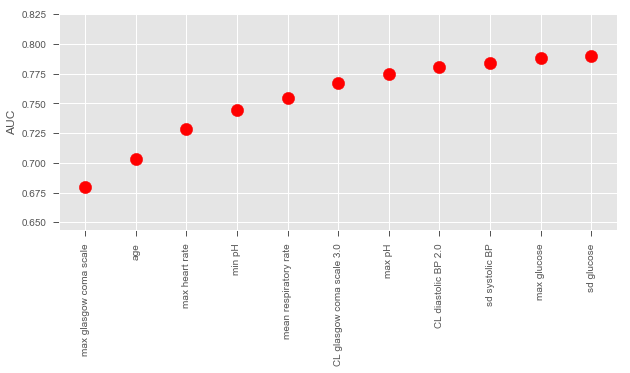

In [40]:
plt.figure(num=None, figsize=(10, 4))
plt.scatter(x = range(1,results_selected.shape[0]+1,1), y = results_selected['Performance'], c = 'red', s = 150)
plt.xticks(range(1,results_selected.shape[0]+1,1),results_selected['Feature'], rotation = 'vertical')
plt.ylabel('AUC')
plt.show()

According to SFS, important features that help predict the outcome are:
        
* Maximum **GCS**, decrease in **GCS** during the first hours in the ICU associated with hgh mortality (cluster 3)

* **Age**

* Maximum **heart rate**

* Minimum and maximum **pH**

* Mean **respiratory rate**

* Small increase in **diastolic BP** during the first 24 hours (cluster 2)

* Variation in **systolic BP**

* Maximum and variation in **glucose** 


In the exercises you will investigate how these conclusions change when a different data partitioning is used for training and testing. You can do this by changing the random seed.

Remember that for large number of features (85 in our case) we cannot compute the best subset sequence. This would mean testing all combinations of 85 features, 1 to 85 at a time. It is hard enough to calculate the number of combinations, let alone train models for every one of them. That is why everyone uses greedy algorithms that lead to sub-optimal solutions. Even k-means, which is very fast (one of the fastest clustering algorithms available), falls in local minima. 

#### Recursive Feature Elimination (RFE) 

Recursive feature elimination is similar to forward stepwise selection, only in this case features are recursively eliminated (as opposed to being recursively added) from the feature set. It can be implemented using the RFE function from sklearn. In the documentation you will find:

"Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a 'coef_' attribute or through a 'feature_importances_' attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached."

The disadvantage of using the 'sklearn' implementation of RFE is that you are limited to using 'coef_' or 'feature_importances_' attributes to recursively exclude features. Since LR retrieves a 'coef_' attribute, this means RFE will recursively eliminate features that have low coefficients, and not features giving the lower average sensitivity specificity as we would like to if we were to follow the example given with SFS.

Similarly to SFS, a stoping criteria must also be defined. If the number of features is not given ('n_features_to_select' = None), half of the features are automatically selected. For illustrative purposes, the next example shows how to use RFE to select 13 features:


In [41]:
from sklearn.feature_selection import RFE

n_features_to_select = 13

logreg = LogisticRegression(random_state = 1)
rfe = RFE(logreg, n_features_to_select)
rfe = rfe.fit(X_train, y_train.values.ravel())


The attribure 'support_' gives a mask of selected features:

In [42]:
selected_features_rfe = X_train.columns[rfe.support_]

print('Number of features selected: ' + str(len(X_train.columns[rfe.support_])))
print()
print('Selected features:')
display.display( selected_features_rfe)

Number of features selected: 13

Selected features:


Index(['min diastolic BP', 'min heart rate', 'min mean BP', 'max heart rate',
       'sd glasgow coma scale', 'sd oxygen saturation', 'sd temperature',
       'sd pH', 'mean glasgow coma scale', 'mean glucose',
       'mean respiratory rate', 'mean temperature', 'age'],
      dtype='object')

The attribute 'ranking_' gives the feature ranking. Features are ranked according to when they were eliminated and selected features are assigned rank 1:

In [43]:
rfe.ranking_

array([ 1, 52,  6,  1,  1, 64, 20, 31, 43, 11, 16,  3, 72,  1, 19,  5,  9,
       26, 46, 57, 45,  1, 24,  8, 13,  1, 14,  7,  1,  1, 10,  1,  1, 15,
       32, 30,  1, 53,  1, 38,  1, 51, 37, 35, 68, 36, 40, 39,  4,  2, 17,
       73, 69, 25, 67, 50, 48, 41, 49, 70, 60, 61, 63, 62, 18, 27, 28, 29,
       65, 66, 42, 47, 58, 71, 33, 44, 34, 22, 59, 21, 23, 12, 56, 55, 54])

For example, the least important feature accoding to RFE is:

In [44]:
X_train.columns[rfe.ranking_.argmax()]

'CL glucose 1.0'

Note that this not means that this particular cluster tendency of glucose is not important; such conclusion cannot be drawn due to the presence of other features that are highly correlated with this one.

SFS and RFE selected the following features in common:

In [45]:
list(set(selected_features_rfe) & set(selected_features_sfs))

['age', 'max heart rate', 'mean respiratory rate']

### Model testing

Feature selection has been performed using the training set to train and validate the models. In the next steps, the performance will be evaluated using an independent test set not used before. First, we will fit a LR model to the training data on the feature set selected by SFS:

In [46]:
model = LogisticRegression(random_state = 1)
model.fit(X_train[selected_features_sfs], y_train.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Next, a general function called 'model_evaluation' is created in order to:

1. give probability estimates for unseen data. This is achivied using the 'predict_proba' function;

2. evaluate model performance using both training and test sets.

In [47]:
def model_evaluation(model, X_train, y_train, X_test, y_test, print_):
    
    # tune - parameter estimation 
    print('TRAINING SET')
    y_pred_prob_train = model.predict_proba(X_train)
    threshold, AUC_train, sens_train, spec_train = performance(y_train, np.delete(y_pred_prob_train, 0, 1), print_)

    # test
    print('TEST SET')
    y_pred_prob_test = model.predict_proba(X_test)
    _, AUC_test, sens_test, spec_test = performance(y_test, np.delete(y_pred_prob_test, 0, 1), print_, threshold)
    
    # save the results
    results_train = pd.DataFrame(data = [[threshold, AUC_train, sens_train, spec_train, X_train.shape[1]]],
                           columns = ['Threshold','AUC', 'Sensitivity', 'Specificity', '# features'])

    results_test = pd.DataFrame(data = [[threshold, AUC_test, sens_test, spec_test, X_train.shape[1]]],
                           columns = ['Threshold','AUC', 'Sensitivity', 'Specificity', '# features'])
        
    return results_train, results_test, y_pred_prob_train, y_pred_prob_test


We can call the function to evaluate the previous model on test data:

TRAINING SET
Threshold: 0.39
TP: 631
TN: 970
FP: 308
FN: 201
Accuracy: 0.76
Sensitivity: 0.76
Specificity: 0.76
AUC: 0.82


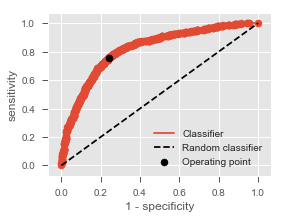

TEST SET
Threshold: 0.39
TP: 158
TN: 727
FP: 283
FN: 64
Accuracy: 0.72
Sensitivity: 0.71
Specificity: 0.72
AUC: 0.79


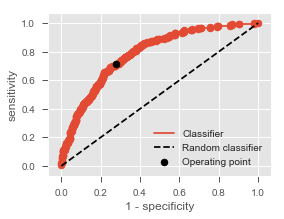

In [48]:
results_train, results_test, y_pred_prob_train, y_pred_prob_test = model_evaluation(model, X_train[selected_features_sfs], y_train, X_test[selected_features_sfs], y_test, print_ = 1)


Results are assigned to a DataFrame for future reference, with the label 'LR SFS': 

In [49]:
all_results_train = pd.DataFrame()
all_results_test = pd.DataFrame()
all_results_train = all_results_train.append(results_train.rename(index={results_train.index[-1]: 'LR SFS'}))
all_results_test = all_results_test.append(results_test.rename(index={results_test.index[-1]: 'LR SFS'}))


The coefficients of the model can be visualized using the 'coef_' attribute. The next function takes a LR model and column names and plots the model coefficients in ascending order:


In [50]:
def print_coef(model, columns):
    """ Plot logistic regression model coefficients """ 
    coef = pd.DataFrame(np.transpose(model.coef_), index = columns, columns = ['Coefficients'])
    coef = coef.sort_values(by=['Coefficients'])
    plt.figure(figsize = (15,6))
    plt.scatter(x = range(len(coef)), y = coef['Coefficients'])
    plt.xticks(range(len(coef)),coef.index, rotation = 'vertical')
    plt.ylabel('LR coefficients')
    plt.show()
    

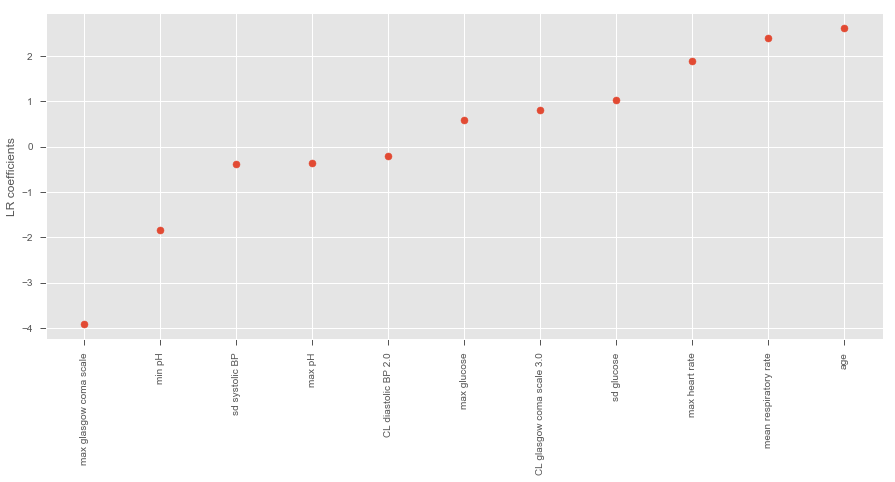

In [51]:
print_coef(model, X_train[selected_features_sfs].columns)


The results seem to cohere with expected clinical practice. There are enough variables in the model which correlate with mortality as we would expect them to. This increases our faith in the remainder of those variables whose association with mortality in clinical practice is not inherently obvious. The results evoke interesting relationships between other variables which are less well known to affect mortality, such as, for instance, glucose. 

The same process can be repeated for RFE:

TRAINING SET
Threshold: 0.4
TP: 638
TN: 981
FP: 297
FN: 194
Accuracy: 0.77
Sensitivity: 0.77
Specificity: 0.77
AUC: 0.85


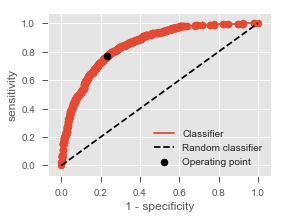

TEST SET
Threshold: 0.4
TP: 162
TN: 751
FP: 259
FN: 60
Accuracy: 0.74
Sensitivity: 0.73
Specificity: 0.74
AUC: 0.82


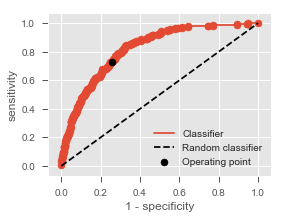

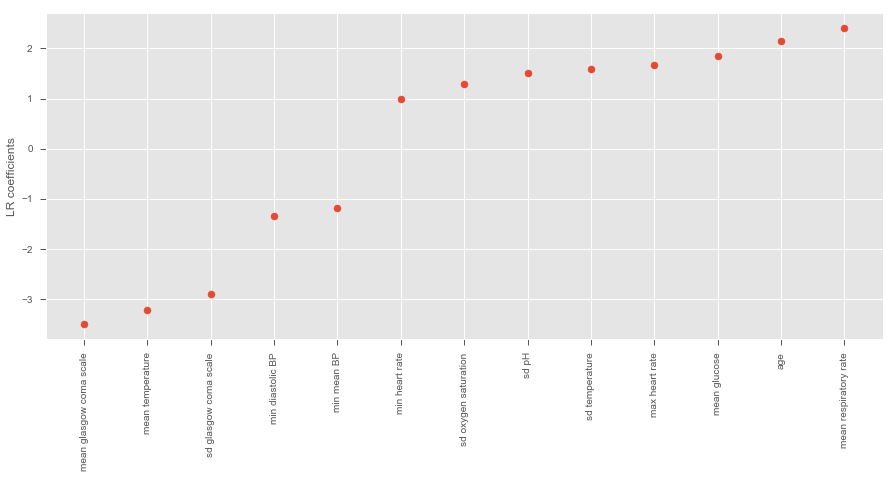

In [52]:
model = LogisticRegression(random_state = 1)
model.fit(X_train[selected_features_rfe], y_train.values.ravel())
results_train, results_test, y_pred_prob_train, y_pred_prob_test = model_evaluation(model, X_train[selected_features_rfe], y_train, X_test[selected_features_rfe], y_test, print_ = 1)
print_coef(model, X_train[selected_features_rfe].columns)

all_results_train = all_results_train.append(results_train.rename(index={results_train.index[-1]: 'LR RFE'}))
all_results_test = all_results_test.append(results_test.rename(index={results_test.index[-1]: 'LR RFE'}))


### k-Nearest neighbors (kNN)

The second simple algorithm investigated in this work is k-nearest neighbors. It is known as a "lazy" algorithm, since it does not do anything during the learning phase: the model is essentially the entire training dataset. When a prediction is required for an unseen observation, kNN will search through the entire training set for the $k$ most similar observations. The prediction is given by the majority voting of those $k$ nearest neighbors. The similarity measure is dependent on the type of data. For real-valued data, the Euclidean distance can be used. For other types of data, such as categorical or binary data, the Hamming distance is recommended. In this work we will use only the Euclidean distance.

A very common alternative to the straigthforward kNN is weighted kNN, where each point has a weight proportional to its distance. For example, with inverse distance weighting, each point has a weight equal to the inverse of its distance to the point to be classified. This means that neighboring points have a higher vote than farther points. As an example, we will use the 'KNeighborsClassifier' function from 'sklearn' with 3 neighbors, the parameter 'weights' set to 'distance', in order to have weighted votes and the features selected throught SFS.

Warning: In sklearn, if there is a tie in majority voting, for instance if you provide $k = 2$ and the two neighbors have identical distances but different class labels, the results will depend on the ordering of the training data. Therefore, it is recommended to use an odd number of k. 


Threshold: 1
TP: 125
TN: 816
FP: 194
FN: 97
Accuracy: 0.76
Sensitivity: 0.56
Specificity: 0.81
AUC: 0.69


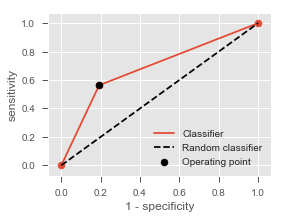

In [53]:
from sklearn.neighbors import KNeighborsClassifier

# instantiate learning model
knn = KNeighborsClassifier(n_neighbors = 3, weights = 'distance')

# fitting the model
knn.fit(X_train[selected_features_sfs], y_train.values.ravel())

# predict the response
y_pred = knn.predict(X_test[selected_features_sfs])

# evaluate the performance
threshold, AUC_test, sens_test, spec_test = performance(y_test, pd.DataFrame(y_pred), print_ = 1)

# save the results
all_results_test.loc['KNN SFS'] = [threshold, AUC_test, sens_test, spec_test, len(selected_features_sfs)]
all_results_train.loc['KNN SFS'] = np.nan


Running the same algorithm with the features selected through RFE yields very similar results. You can check for yourself by substituing the input vector in the previous script.

## Decision tree

Most ICU severity scores are constructed using logistic regression, which imposes stringent constraints on the relationship between explanatory variables and outcome. In particular, logistic regression relies on the assumption of a linear and additive relationship between the outcome and its predictors. Given the complexity of the processes underlying death in ICU patients, this assumption might be unrealistic.

We hope to improve the prediction obtained by LR by using a nonparametritc algorithm such as a decision tree. Since this type of algorithm does not make strong assumptions about the form of the mapping function, they are good candidates when you have a lot of data and no prior knowledge, and when you do not want to worry too much about choosing the right features.


### CART algorithm 

This work will focus on the CART algorithm, which is one of the most popular algorithms for learning a decision tree. The selection of variables and the specific split is chosen using a greedy algorithm to minimize a cost function. Tree construction ends using a predefined stopping criterion, such as a minimum number of training instances assigned to each leaf node of the tree.

#### Greedy Splitting

The greedy search consists of recursive binary splitting, a process of dividing up the input space. All input variables and all possible split points are evaluated and chosen in a greedy manner (the very best split point is chosen each time). All values are lined up and different split points are tried and tested using a cost function. The split with the lowest cost is selected. 

For classification, the **Gini index** (G) function (also known as Gini impurity) is used which provides an indication of how "pure" the leaf nodes are. It gives an idea of how good a split is by how mixed the classes are in the two groups created by the split:

* **perfect class purity**: a node that has all classes of the same ($G=0$)
* **worst class purity**: a node that has a 50-50 split of classes ($G=0.5$)

The $G$ for each node is weighted by the total number of instances in the parent node. For a chosen split point in a binary classification problem, $G$ is calculated as:

$G = ((1 -g1_1^2 + g1_2^2) \times \frac{ng1}{n})+ ((1 - g2_1^2 + g2_2^2) \times \frac{ng2}{n})$, where:
* $g1_1$: proportion of instances in group 1 for class 1
* $g1_2$: proportion of instances in group 1 for class 2
* $g2_1$: proportion of instances in group 2 for class 1
* $g2_2$: proportion of instances in group 2 for class 2
* $ng1$: total number of instances in group 1
* $ng2$: total number of instances in group 2 
* $n$: total number of instances we are trying to group from the parent node

#### Stopping Criterion

The most common stopping procedure is to use a minimum count on the number of training observations assigned to each leaf node. If the count is less than some minimum then the split is not accepted and the node is taken as a final leaf node. The minimum count of training observations is tuned to the dataset. It defines how specific to the training data the tree will be. Too specific (e.g. a count of 1) and the tree will overfit the training data and likely have poor performance on the test set.

The CART algorithm can be implemented in sklearn using the 'DecisionTreeClassifier' function from sklearn.ensemble. Next follows a list of important parameters to have in consideration when training the model:

* **criterion**: function to measure the quality of a split.
Default="gini"

* **splitter**: strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.
Default="best"

* **max_features**: maximum number of features in each tree.
Default is sqrt(n_features)

* **max_depth**: maximum depth of the tree.
If None, nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

* **min_samples_split**: minimum number of samples required to split an internal node.
Default=2

* **min_samples_leaf**: minimum number of samples required to be at a leaf node. 
Default=1

* **max_leaf_nodes**: grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
default=None

* **random_state**: if int, seed used by the random number generator.
Default=None

In the next example, a small decision tree (maximum depth = 5) is created. Since the algorithm has embedded feature selection, we can use all the extracted features as input without having to worry about dimensionality issues.

According to the documentation in 'sklearn':

"The features are always randomly permuted at each split. Therefore, the best found split may vary, even with the same training data and 'max_features=n_features', if the improvement of the criterion is identical for several splits enumerated during the search of the best split. To obtain a deterministic behaviour during fitting, 'random_state' has to be fixed."

TRAINING SET
Threshold: 0.44
TP: 683
TN: 981
FP: 297
FN: 149
Accuracy: 0.79
Sensitivity: 0.82
Specificity: 0.77
AUC: 0.87


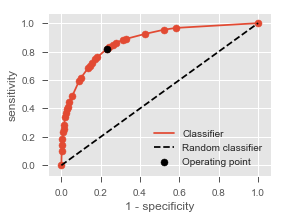

TEST SET
Threshold: 0.44
TP: 159
TN: 705
FP: 305
FN: 63
Accuracy: 0.7
Sensitivity: 0.72
Specificity: 0.7
AUC: 0.77


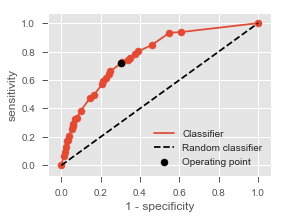

In [54]:
# from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

clf_gini = DecisionTreeClassifier(criterion = 'gini', max_depth = 5, min_samples_leaf = 20,
                                  min_samples_split = 20, random_state = 2, splitter = 'best')

clf_gini.fit(X_train, y_train)
results_train, results_test, y_pred_prob_train, y_pred_prob_test = model_evaluation(clf_gini, X_train, y_train, X_test, y_test, print_ = 1)


You can investigate how the bias and variance are affected by different choices of parameters. Remember:

* **Bias**: how the algorithm performs on the training set.
* **Variance**: how much worse the algorithm does on the test set than the training set.

<img src="biasvariance.png" style="width: 400px;"/>

Comparing the training and test results, is seems that DT is overfitting the training data (high variance).

### Tree visualization

In order to visualize the tree, some extra packages need to be installed ('pydot' and 'graphviz'). Use the following example to visualize the tree created in the previous step:

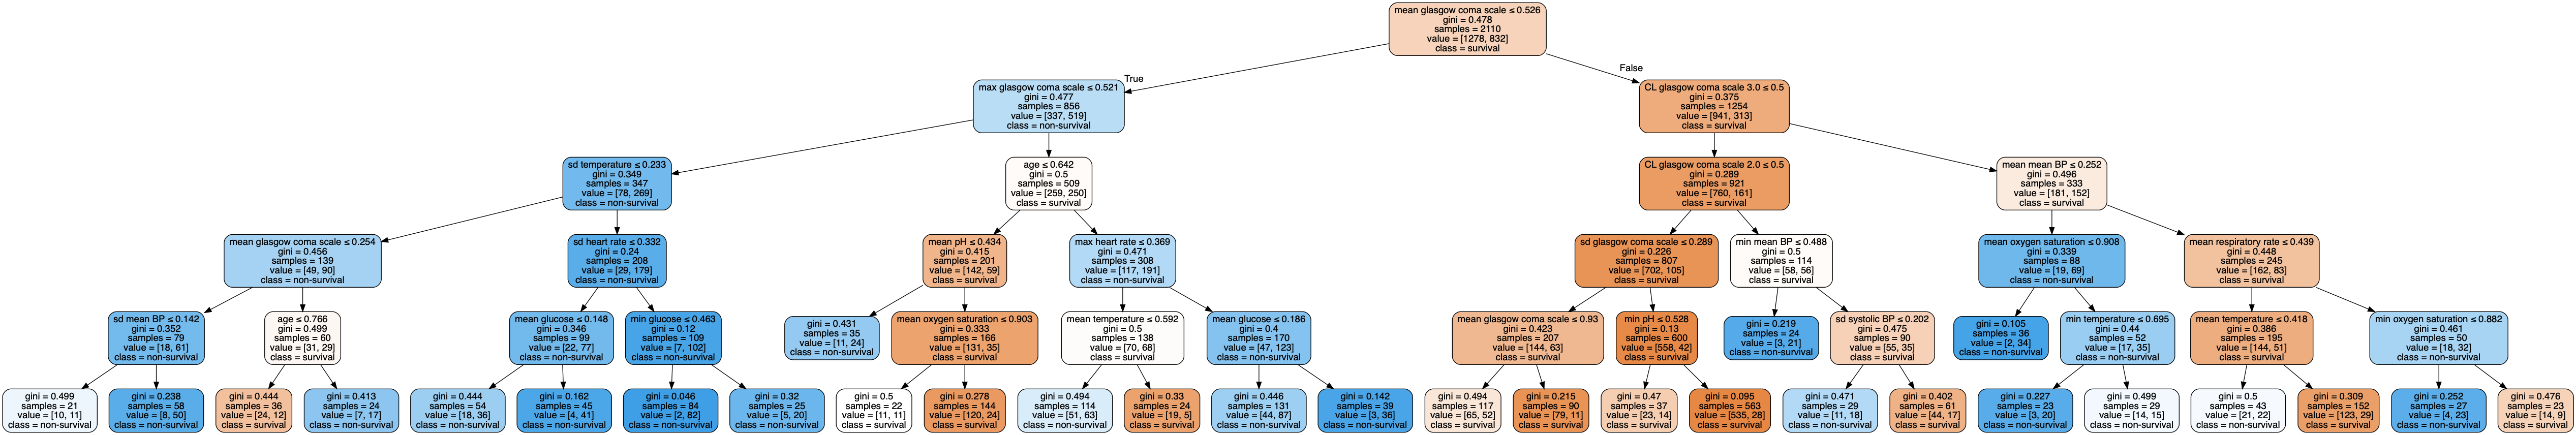

In [55]:
from sklearn.externals.six import StringIO  
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(clf_gini, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                class_names=["survival", "non-survival"],
                feature_names=X_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

With the binary tree representation shown above, making predictions is relatively straightforward.

### Feature importance

As you can see in the previous figure, not all features are selected. The $feature_importances_$ attribute gives the relative importance of each feature in the model. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance. Features with relative importance greater than 0 correspond to features that were selected by the model. The next script plots the features in descending order of relative importance.

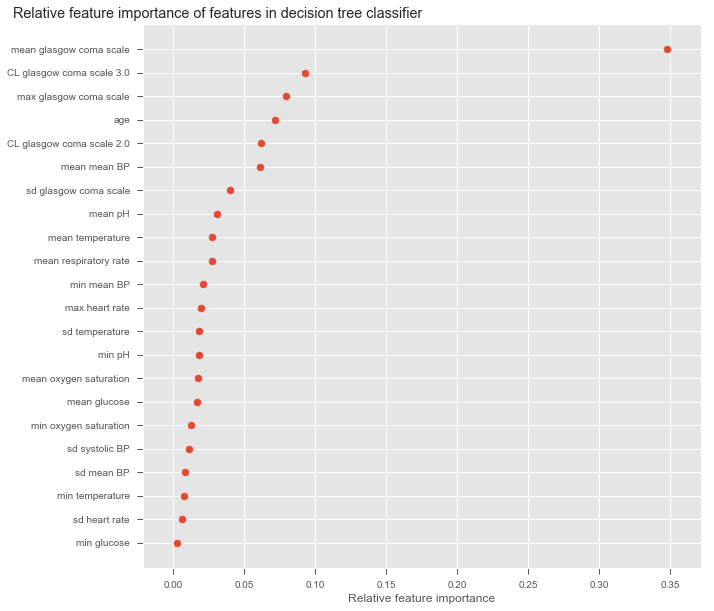

In [56]:
def plot_feat_importance(columns, feature_importances_, *topx):
    list_feat = list(zip(columns, feature_importances_))
    pd_list_feat = pd.DataFrame(list_feat)
    pd_list_feat.columns = ('Feature','Importance')
    pd_list_feat = pd_list_feat.sort_values(by='Importance')
    pd_list_feat = pd_list_feat[pd_list_feat['Importance']>0]

    if topx:
        pd_list_top = pd_list_feat.iloc[topx[0]:]
    else:
        pd_list_top = pd_list_feat
    plt.figure(figsize=(10,10))
    plt.scatter(y = range(len(pd_list_top)), x = pd_list_top['Importance'])
    plt.yticks(range(len(pd_list_top)),pd_list_top['Feature'])
    plt.title("Relative feature importance of features in decision tree classifier", ha = 'right')
    plt.xlabel("Relative feature importance")
    plt.show()
    return pd_list_top

pd_list_top = plot_feat_importance(X_train.columns, clf_gini.feature_importances_)

Again, we will store the results, but in this case we need to update the actual number of features used:

In [57]:
all_results_train = all_results_train.append(results_train.rename(index={results_train.index[-1]: 'DT'}))
all_results_test = all_results_test.append(results_test.rename(index={results_test.index[-1]: 'DT'}))
all_results_train.loc['DT', '# features'] = len(pd_list_top)
all_results_test.loc['DT', '# features'] = len(pd_list_top)


## Random forest

Random forest comprises split-variable selection, sub-sampling and bootstrap aggregating (bagging).

> "The essential idea in bagging is to average many noisy but approximately unbiased models, and hence reduce the variance. Trees are ideal candidates for bagging, since they can capture complex interaction structures in the data, and if grown sufficiently deep, have relatively low bias. Since trees are notoriously noisy, they benefit greatly from the averaging". Friedman et al. - 2008 - The Elements of Statistical Learning.
 
Next follows a description of the Random Forest algorithm for classification during the learning and test phases:

### Training

$B:$ Number of trees

1. For $b=1$ to $B$

    1.1. Draw a bootstrap sample of size $N_b$ from the training data (bootstrap = random sampling with replacement).
    
    1.2. Grow a random tree $T_b$ to the bootstrapped data, by recursively repeating the following steps for each terminal node of the tree, until the minimum node size $n_{min}$ is reached. See **CART** algorithm.
        
    * Select *m* variables at random from the $p$ variables

    * Pick the best variable/split-point among $m$

    * Split the node into two daughter nodes
    

2. Output the ensemble of trees

### Testing

Let $C_b(x_i)$ be the predicted class probability of the $b$th tree in the ensemble for observation $x_i$. Then, the predicted class probability of the random forest for observation $x_i$ is: 

$C_{rf}^B(x_i)=  \frac{1}{B}\sum_{b=1}^{B}C_b(x_i)$

The predicted class probabilities of an input sample are computed as the mean predicted class probabilities of the trees in the forest. The class probability of a single tree is the fraction of samples of the same class in a leaf.

The algorithm can be implemented in 'sklearn' using the 'RandomForestClassifier'. Similarly to the decision tree, important parameters to define are:

* **n_estimators**: number of trees in the forest.

* **criterion**: function to measure the quality of a split.
Default="gini"

* **max_features**: maximum number of features in each tree.
Default is sqrt(n_features)

* **max_depth**: maximum depth of the tree.
If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

* **min_samples_split**: minimum number of samples required to split an internal node.
Default=2

* **min_samples_leaf**: minimum number of samples required to be at a leaf node (external node). 
Default=1

* **random_state**: if int, seed used by the random number generator.
Default=None

* **bootstrap**: Whether bootstrap samples are used when building trees. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True.
Default=True

The next example shows how to build a RF classifier with 100 trees and a maximum depth of 10:

TRAINING SET
Threshold: 0.4
TP: 818
TN: 1256
FP: 22
FN: 14
Accuracy: 0.98
Sensitivity: 0.98
Specificity: 0.98
AUC: 1.0


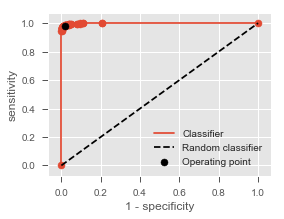

TEST SET
Threshold: 0.4
TP: 175
TN: 741
FP: 269
FN: 47
Accuracy: 0.74
Sensitivity: 0.79
Specificity: 0.73
AUC: 0.84


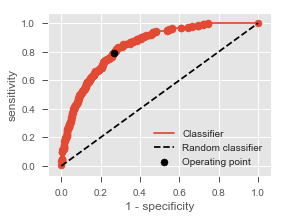

In [58]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, bootstrap = True, criterion = 'gini', 
                            max_depth = 10, random_state = 2)

rf.fit(X_train, y_train.values.ravel())
results_train, results_test, y_pred_prob_train, y_pred_prob_test = model_evaluation(rf, X_train, y_train, X_test, y_test, print_=1)

all_results_train = all_results_train.append(results_train.rename(index={results_train.index[-1]: 'RF'}))
all_results_test = all_results_test.append(results_test.rename(index={results_test.index[-1]: 'RF'}))


As you can see, in the previous RF configuration the training error is very low. This should make you suspect of/expect high variance. In fact, the performance in the test set is significantly lower. In order to reduce overfitting, we can reduce the depth of the trees and increase the 'min_samples_split'.


TRAINING SET
Threshold: 0.43
TP: 730
TN: 1120
FP: 158
FN: 102
Accuracy: 0.88
Sensitivity: 0.88
Specificity: 0.88
AUC: 0.95


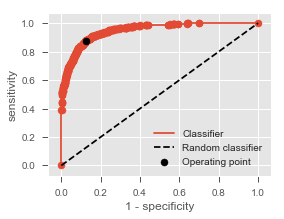

TEST SET
Threshold: 0.43
TP: 164
TN: 777
FP: 233
FN: 58
Accuracy: 0.76
Sensitivity: 0.74
Specificity: 0.77
AUC: 0.84


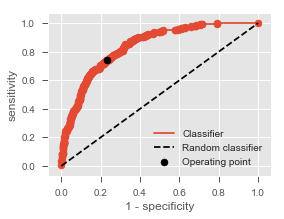

In [59]:
from sklearn.ensemble import RandomForestClassifier

print_ = 1
rf = RandomForestClassifier(n_estimators = 100, bootstrap = True, criterion = 'gini', 
                            max_depth = 7, min_samples_split = 30, random_state = 2)

rf.fit(X_train, y_train.values.ravel())
results_train, results_test, y_pred_prob_train, y_pred_prob_test = model_evaluation(rf, X_train, y_train, X_test, y_test, print_)

all_results_train = all_results_train.append(results_train.rename(index={results_train.index[-1]: 'RF small'}))
all_results_test = all_results_test.append(results_test.rename(index={results_test.index[-1]: 'RF small'}))


We were able to decrease the variance, but we still have moderate performance in the test set. Ideally, the performance should be evaluated for various combinations of parameters, and the combination giving the best performance should be selected. The performance of the selected set could then be evaluated using a validation set not used before.


### Feature importance

At each split in each tree, the improvement in the split-criterion ($G$) is the importance measure attributed to the splitting feature, and is accumulated over all the trees in the forest separately for each feature. The same function created for DT can be used for RF: 

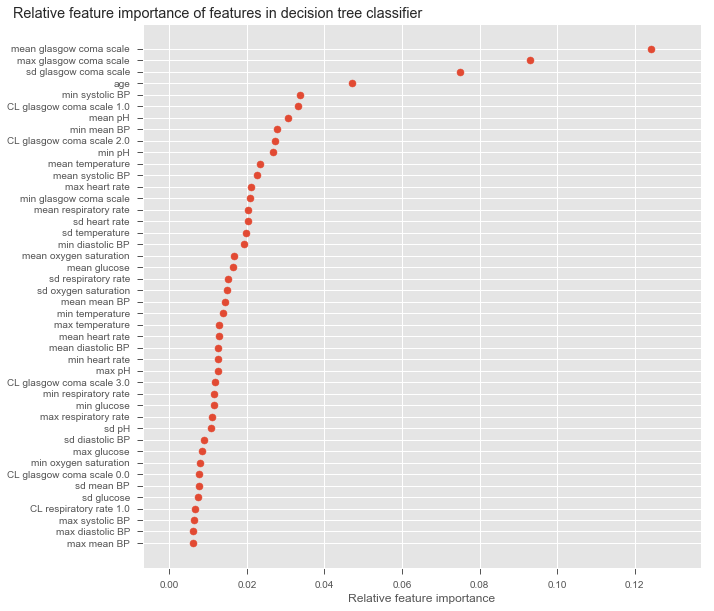

In [60]:
pd_list_top = plot_feat_importance(X_train.columns, rf.feature_importances_, 40)

Update the actual number of features used in the DT:

In [61]:
all_results_train.loc['RF small', '# features'] = len(pd_list_top)
all_results_test.loc['RF small', '# features'] = len(pd_list_top)


The features to which RF assigns higher feature importance are consistent with previous findings. Several features extracted from GCS appear at the top. 

# Comparison of classifiers

The next example summarizes the performance of several classifiers and their ability to generalize. For better assessing the classifieres ability to generalize, the difference between training and test performance is plotted.

Performance in training set


Threshold   AUC  Sensitivity  Specificity  # features
LR SFS         0.39  0.82         0.76         0.76        11.0
LR RFE         0.40  0.85         0.77         0.77        13.0
KNN SFS         NaN   NaN          NaN          NaN         NaN
DT             0.44  0.87         0.82         0.77        22.0
RF             0.40  1.00         0.98         0.98        85.0
RF small       0.43  0.95         0.88         0.88        44.0


Performance in test set


Threshold   AUC  Sensitivity  Specificity  # features
LR SFS         0.39  0.79         0.71         0.72        11.0
LR RFE         0.40  0.82         0.73         0.74        13.0
KNN SFS        1.00  0.69         0.56         0.81        11.0
DT             0.44  0.77         0.72         0.70        22.0
RF             0.40  0.84         0.79         0.73        85.0
RF small       0.43  0.84         0.74         0.77        44.0

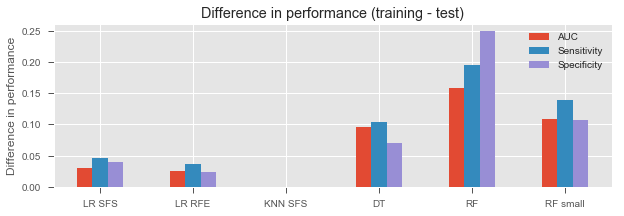

In [62]:
print('Performance in training set')
display.display(np.round(all_results_train, decimals = 2))
print()

print('Performance in test set')
display.display(np.round(all_results_test, decimals = 2))
print()

diff = all_results_train-all_results_test
diff[['AUC', 'Sensitivity','Specificity']].plot(kind = 'bar', figsize = (10,3))
plt.ylabel('Difference in performance')
plt.xticks(rotation=None)
plt.title('Difference in performance (training - test)')
plt.show()

# Discussion

In the next section, critical aspects of the study conducted are discussed. 


## Selecting one model

What is the best model? At this point it is probable that the reader is posing this question. The answer to what is the best model, or what model should be selected, is not straightforward. At this point, it really is about selecting a good path to continue exploring. A single decision tree is clearly not the way to go in terms of performance, but it can be useful if interpretability is a must. LR is also interpretable when the feature set contains a resonable number of features. So if interpretability is important, LF with RFE or SFS should be considered. RF performs well in the test set but the increase in performance relatively to simpler models is very small. The choice depends on reaching a good trade-off between what's more important; e.g., if sensitivity is very important, and not so much interpretability, them the first RF should be chosen.

## Training test and validation

Before making any conclusions about the performance, it is advisable to change the data partitions used for training, testing and validating. A single data partitioning has been used in order to facilitate the presentation of ideas, but ideally the evaluation should not be limited to a single random data division. Cross validation can be used to investigate the variablity in performance when different data partitions are used. Following this approach, all data is used for training and testing the models and the results are averaged over the rounds.

## Bias/variance

Decision tree based models have high variance, i.e., the trees are probably overfitting the training data and this hampers their ability to generalize. Again, cross-validation should be performed - we would probably get very different DTs for different training partitions (which is why RF is better!). As mentioned before, the bias/variance problem could be addressed by training/validating models for a range of distinct combinations of parameters and selecting a set that minimizes overfit to the training data (low bias) and that at the same time performs well in the validation set (low variance).


# Exercises

## 1. Daily prediction

It is useful to evaluate the performance of the classifier using data from the first day. It will give us a more realistic sense of how the classifier would behave in a real setting if we wanted a decision at the end of the first day. 

We have performed dimensionality reduction by extracting relevant information from the time series and we have done this for the complete series (48h). Your job is to do this separately for each 24h and see how the performance changes.
  

## 2. Clustering patterns

Clustering has been employed for patient stratification. Data were normalized for each patient individually so that the groups would reflect physiological time trends. How do the patterns change if:
    
1. the random seed used to generate the training and test sets changes;
2. the random seed used to initiate the cluster centers changes;  
3. data is not normalized;
4. data is normalized for the entire training set at once?

## 3. Class imbalance

Undersampling has been used in order to mitigate bias toward a predominant class. Class balancing can also be performed by sampling an equal number of observations from each class. In 'sklearn', you can use the parameter 'class_weight' in order to control for imbalanced training data when learning logistic regression, decision trees or random forest:

* class_weight = {class_label: weight}: weights associated with classes. If not given, all classes are supposed to have weight one.

* class_weight = 'balanced': uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. It basically increases the weight of making an error with the under-represented class. 

Investigate how class_weight='balanced' impacts the performance of the models.

## 4. Bias/Variance

Investigate how bias and variance are affected by different choices of parameters.

# Recommended literature

1. [Machine Learning Yearning](http://www.mlyearning.org/) (2018) by Andre Ng (draft version currently available)
2. [The elements of statistical learning](https://web.stanford.edu/~hastie/Papers/ESLII.pdf) (2001) by Friedman J, Hastie T, Tibshirani R.
3. [Secondary Analysis of Electronic Health Records](https://link.springer.com/book/10.1007%2F978-3-319-43742-2) (2016) by MIT Critical Data
4. [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook) (2016) by Jake VanderPlas
5. [Hands-On Machine Learning with Scikit-Learn and TensorFlow](http://shop.oreilly.com/product/0636920052289.do) (2017) by Aurélien Géron